[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Unscented Kalman Filters

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function
import matplotlib.pyplot as plt
import book_format
book_format.load_style()

In the last chapter we discussed the difficulties that nonlinear systems pose. This nonlinearity can appear in two places. It can be in our measurements, such as a radar that is measuring the slant range to an object. Slant range requires you to take a square root to compute the x,y coordinates:

$$x=\sqrt{slant^2 - altitude^2}$$

The nonlinearity can also occur in the process model - we may be tracking a ball traveling through the air, where the effects of gravity and air drag lead to highly nonlinear behavior. The standard Kalman filter performs poorly or not at all with these sorts of problems.

In the last chapter I showed you a plot like this. I have altered the equation somewhat to emphasize the effects of nonlinearity.

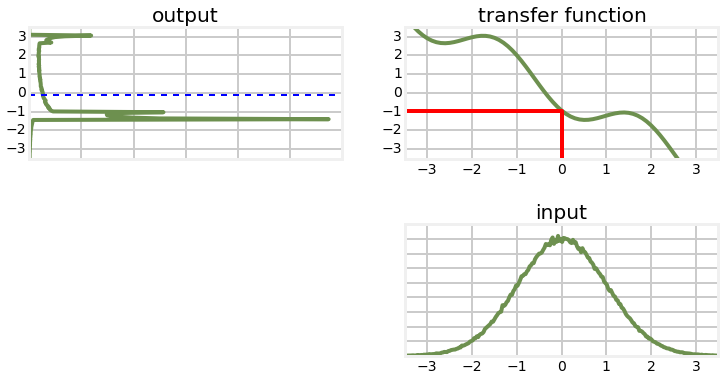

In [2]:
from nonlinear_plots import plot_transfer_func
from numpy.random import normal
import numpy as np

data = normal(loc=0.0, scale=1, size=500000)

def g(x):
    return (np.cos(4*(x/2+0.7)))-1.3*x

plot_transfer_func (data, g, lims=(-3.5,3.5), num_bins=300)

I generated this by taking 500,000 samples from the input, passing it through the nonlinear transform, and building a histogram of the result. From the output histogram we can compute a mean and standard deviation which would give us an updated, albeit approximated Gaussian.

It has perhaps occurred to you that this sampling process constitutes a solution to our problem. Suppose for every update we generated 500,000 points, passed them through the function, and then computed the mean and variance of the result. This is called a 'Monte Carlo' approach, and it used by some Kalman filter designs, such as the *Ensemble filter*. Sampling requires no specialized knowledge, and does not require a closed form solution. No matter how nonlinear or poorly behaved the function is, as long as we sample with enough points we will build an accurate output distribution.

"Enough points" is the rub. The graph above was created with 500,000 points, and the output is still not smooth. You wouldn't need to use that many points to get a reasonable estimate of the mean and variance, but it will require many points. What's worse, this is only for 1 dimension. In general, the number of points required increases by the power of the number of dimensions. If you only needed $50$ points for 1 dimension, you'd need $50^2=2,500$ for two dimensions, $50^3=125,000$ for three dimensions, and so on. So while this approach does work, it is very computationally expensive. The Unscented Kalman filter uses a similar technique but reduces the amount of computation needed by a drastic amount by using a deterministic method of choosing the points.

## Choosing Sigma Points

Let's look at the problem in terms of a 2D covariance ellipse. I choose 2D merely because it is easy to plot. Naturally this will extend to any number of dimensions. Assuming some arbitrary nonlinear function, we will take random points from the first covariance ellipse, pass them through the nonlinear function, and plot their new position.

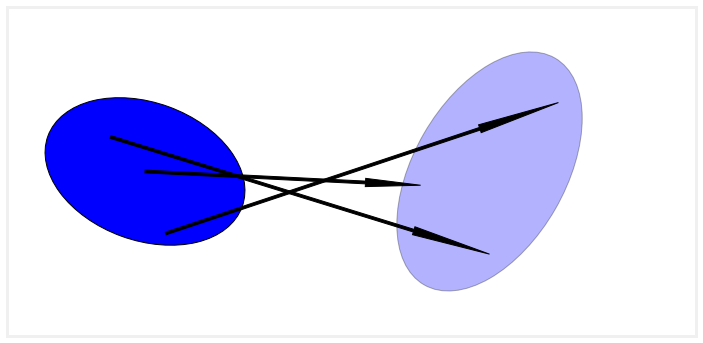

In [3]:
import ukf_internal
ukf_internal.show_2d_transform()

Here on the left we show an ellipse depicting the $1\sigma$ distribution of two state variables. The arrows show how three randomly sampled points might be transformed by some arbitrary nonlinear function to a new distribution. The ellipse on the right is drawn semi-transparently to indicate that it is an *estimate* of the mean and variance of this collection of points - if we were to sample, say, a million points the shape of the points might be very far from an ellipse. 

Let's look at that by running a bunch of points through a nonlinear function. We will write a function to pass randomly generated points with a Gaussian distribution through the system

$$\begin{aligned}x&=x+y\\
y &= 0.1x^2 + y^2\end{aligned}$$ 

for the mean and covariance $$\mu = \begin{bmatrix}0\\0\end{bmatrix}, 
\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

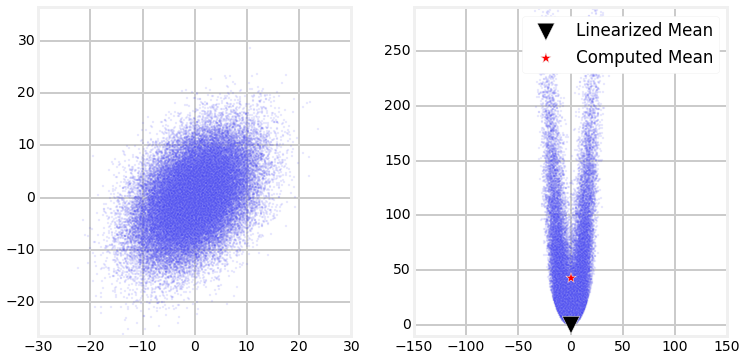

Difference in mean x=-0.026, y=42.890


In [4]:
from numpy.random import randn
import numpy as np
from numpy import sin, cos, tan,log
import matplotlib.pyplot as plt

from numpy.random import multivariate_normal


def f(x,y):
    return x+y, .1*x**2 +y*y

mean = (0, 0)
p = np.array([[32, 15],[15., 40.]])

xs ,ys = multivariate_normal(mean=mean, cov=p, size=50000).T
fxs, fys = [], []
for x,y in zip(xs,ys):
    fx, fy = f(x,y)
    
    fxs.append(fx)
    fys.append(fy)

# Compute mean
mean_fx = f(*mean)

computed_mean_x = np.average(fxs)
computed_mean_y = np.average(fys)

plt.subplot(121)
plt.scatter (xs,ys, marker='.', alpha=0.1)
plt.axis('equal')

plt.subplot(122)
plt.scatter(fxs, fys, marker='.', alpha=0.1)
plt.scatter(mean_fx[0], mean_fx[1], 
            marker='v', s=300,c='k', label='Linearized Mean')
plt.scatter(computed_mean_x, computed_mean_y, 
            marker='*',s=120,c='r', label='Computed Mean')
plt.ylim([-10,290])
plt.xlim([-150,150])
plt.legend(loc='best', scatterpoints=1)
plt.show()
print ('Difference in mean x={:.3f}, y={:.3f}'.format(
       computed_mean_x-mean_fx[0], computed_mean_y-mean_fx[1]))

This plot shows the strong nonlinearity that occurs with this function, and the large error that would result if we linearized the function at (0,0), which is what filters like the Extended Kalman filters do (we will be learning this in the next chapter).

We used 5,000 points to generate this solution. While the computed mean is quite accurate, computing 5,000 points for every update would cause our filter to be very slow. So, what would be fewest number of sampled points that we can use, and what kinds of constraints does this problem formulation put on the points? We will assume that we have no special knowledge about the nonlinear function as we want to find a generalized algorithm that works for any function. For reasons that come clear in the next section, we will call these points *sigma points*.

Let's consider the simplest possible case and see if it offers any insight. The simplest possible system is *identity* - the transformation does not alter the input. In mathematical notation this is just $f(x) = x$. It should be clear that if our algorithm does not work for the identity function then the filter will never converge. In other words, if the input is  1 (for a one dimensional system), the output must also be 1. If the output was different, such as 1.1, then when we fed 1.1 into the transform at the next time step, we'd get out yet another number, maybe 1.23. The filter would run away (diverge). 

The fewest number of points that we can use is one per dimension. This is the number that the linear Kalman filter uses. The input to a Kalman filter for the distribution $\mathcal{N}(\mu,\sigma^2)$ is just $\mu$ itself. So while this works for the linear case, it is not a good answer for the nonlinear case.

Perhaps we can use one point per dimension, but altered somehow. However, if we were to pass some value $\mu+\Delta$ into the identity function $f(x)=x$ it would not converge, so this is not a possible algorithm. We must conclude that a one point sample will not work.

So, what is the next lowest number we can choose? Consider the fact that Gaussians are symmetric, and that we probably want to always have one of our sample points be the mean of the input for the identity function to work. Two points would require us to select the mean, and then one other point. That one other point would introduce an asymmetry in our input that we probably don't want. It would be very difficult to make this work for the identity function $f(x)=x$.

The next lowest number is 3 points. 3 points allows us to select the mean, and then one point on each side of the mean, as depicted on the chart below.

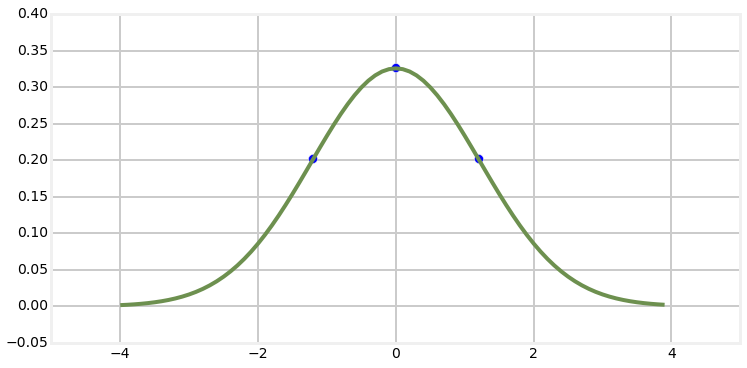

In [5]:
ukf_internal.show_3_sigma_points()

For this to work for identity we will want the sums of the weights to equal one. We can always come up with counterexamples, but in general if the sum is greater or less than one the sampling will not yield the correct output. Given that, we then have to select *sigma points* $\mathcal{X}$ and their corresponding weights so that they compute to the mean and variance of the input Gaussian. So we can write

$$\begin{aligned}
1 &= \sum_i{w_i}\;\;\;&(1) \\
\mu &= \sum_i w_i\mathcal{X}_i\;\;\;&(2) \\
\Sigma &= \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}\;\;\;&(3)
\end{aligned}
$$

If we look at this is should be clear that there is no one unique answer - the problem is unconstrained. For example, if you choose a smaller weight for the point at the mean for the input, you could compensate by choosing larger weights for the rest of the $\mathcal{X}$, and vice versa if you chose a larger weight for it. Indeed, these equations do not require that any of the points be the mean of the input at all, though it seems 'nice' to do so, so to speak.

But before we go on I want to make sure the idea is clear. We are choosing 3 points for each dimension in our covariances. That choice is *entirely deterministic*. Below are three different examples for the same covariance ellipse.

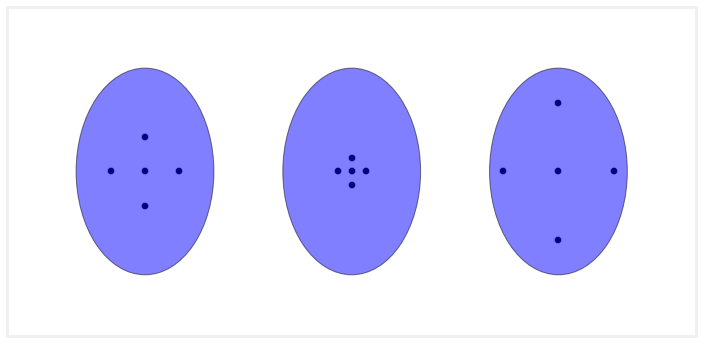

In [6]:
ukf_internal.show_sigma_selections()

Note that while I chose the points to lie along the major and minor axis of the ellipse, nothing in the constraints above require me to do that; however, it is fairly typical to do this. Furthermore, in each case I show the points evenly spaced; again, the constraints above do not require that. However, the technique that we develop in the next section *does* do this. It is a reasonable choice, after all; if we want to accurately sample our input it makes sense to sample in a symmetric manner.

There are several published ways for selecting the sigma points. For now I will stick with the original implementation by Julier and Uhlmann [2]. This method defines a constant kappa ($\kappa$) which controls how spread out the sigma points are. Before we work through the derivation, let's just look at some examples. I will use the class UnscentedKalmanFilter from FilterPy to generate the sigma points for us. It is convention to write

    import UnscentedKalmanFilter as UKF
    
because UKF is the standardized shorthand used in the literature for this filter.

I will plot the sigma points on top of a covariance ellipse showing the first and second deviations, and size them based on the weights assigned to them. I am using the covariance ellipse

$$\mathbf{P} = \begin{bmatrix} 4&2\\2&4\end{bmatrix}$$

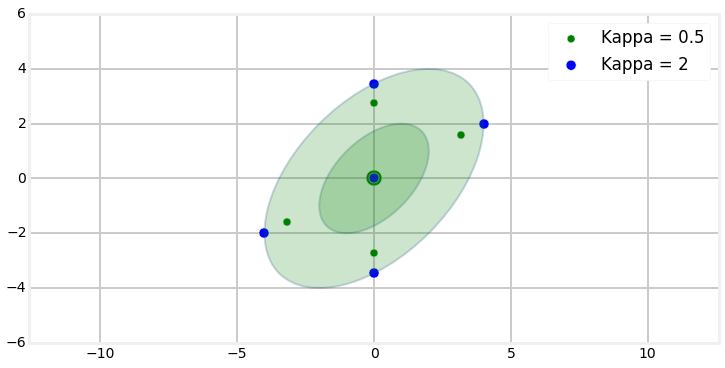

In [7]:
from numpy import array
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import plot_covariance_ellipse

x = array([0, 0])
P = array([[4, 2],
           [2, 4]])

sigmas_kp5 = UKF.sigma_points(x=x, P=P, kappa=0.5)
sigmas_k2 = UKF.sigma_points(x=x, P=P, kappa=2)
W0 = UKF.weights(2, kappa=0.5)
W1 = UKF.weights(2, kappa=2)

for i in range(len(W0)):
    p1 = plt.scatter(sigmas_kp5[i,0], sigmas_kp5[i,1], s=W1[i]*500, c='g')
    p2 = plt.scatter(sigmas_k2[i,0], sigmas_k2[i,1], s=W0[i]*500, c='b')

plt.legend([p1, p2], ['Kappa = 0.5', 'Kappa = 2'])
plot_covariance_ellipse(x, P, facecolor='g', alpha=0.2, std=[1,2])

We can see that the sigma points lie between the first and second deviation, and that the larger $\kappa$ spreads the points out further. Furthermore, the larger $\kappa$ weighs the mean (center point) higher than the smaller $\kappa$, and weighs the rest of the sigma points less. This should fit our intuition - the further a point is from the mean the less we should weight it. We don't know *how* these weights and sigma points are selected yet, but the choices look reasonable.

## Handling the Nonlinearities

I explained at the beginning of the chapter that there are two places for nonlinearities to occur. The first is in the state transition function, and the second is in the measurement function. For the linear Kalman filter we use the equation

$$ \bf{x}^-=\bf{Fx}$$

to propagate the state from one epoch to the next. As you remember F defines a set of linear equations that performs this calculation. However, suppose we are tracking a ball or missile in flight. Air drag causes the behavior to be nonlinear, and therefore there are no linear equations that will compute the state.

The linear Kalman filter uses the measurement function in this equation

$$\hat{\bf{x}} = \bf{K}(\bf{z-Hx}^-)$$

to incorporate the measurements into the state. The term $\bf{Hx}$ converts $\bf{x}$ to a measurement using the linear equations implied by $\bf{H}$.

The UKF assumes that both the measurement function and state transition function are nonlinear, though in some problems only one or the other are nonlinear. If they are nonlinear we can not represent them with a matrix. Instead, we will define a function $h(x)$ for the measurement function and $f(x)$ for the state transition function. We will implement these as Python functions that take a state $x$ and return either a state $x$ for the state transition function, or a measurement vector $z$ for the measurement function. The functions will look something like:

    def hx(x):
        z = # do something to compute z
        return z
        
    def fx(x, dt):
        x_est = x propagated forward in time by dt
        return x_est

## Sigma Point Algorithm

As I already said there are several published algorithms for choosing the sigma points. I will present the method first chosen by the inventors of the UKF. This algorithm is performed for you automatically by the FilterPy UKF code, but it valuable to understand how they are computed.

Our first sigma point is always going to be the mean of our input. We will call this $\mathcal{X}_0$. So,

$$ \mathcal{X}_0 = \mu$$

The corresponding weight for this sigma point is
$$
W_0 = \frac{\kappa}{n+\kappa}
$$
where $n$ is the dimension of the problem, and $\kappa$ is a scaling factor that will be discussed in a moment.

The rest of the sigma points are defined to be


$$ 
\begin{aligned}
\mathcal{X}_i &= \mu + (\sqrt{(n+\kappa)\Sigma})_i\,\,\,\, &\text{for}\text{ i=1 .. n} \\
\mathcal{X}_i &= \mu - (\sqrt{(n+\kappa)\Sigma})_{i-n}\,\,\,\,\, &\text{for}\text{ i=(n+1) .. 2n} \\
\text{and the corresponding weights are} \\
W_i &= \frac{1}{2(n+\kappa)}\,\,\,\text{for i=1,2..2n}
\end{aligned}
$$

$\kappa$ (kappa) is a scaling factor that controls how far away from the mean we want the points to be. A larger kappa will choose points further away from the mean, and a smaller kappa will choose points nearer the mean. Julier and Uhlmann suggest using $\kappa + n = 3$ if the distribution is Gaussian, and perhaps choosing a different value if it is not Gaussian. 

It may not be obvious why this is 'correct', and indeed, it cannot be proven that this is ideal for all nonlinear problems. But you can see that we are choosing the sigma points proportional to the square root of the covariance matrix, and the square root of variance is standard deviation. So, the sigma points are spread roughly according to 1 standard deviation. However, there is an $n$ term in there - the more dimensions there are the more the points will be spread out and weighed less.

## The Unscented Transform

The unscented transform is the core of the algorithm yet it is remarkably simple. Given a set of sigma points and a transfer function we need to compute the new mean and covariance of the points after they have passed through the function. In other words, loop through the sigma points and compute their new position after passing through your nonlinear function. Then just compute the mean and covariance of these points.

In other words, we just compute the mean and covariance from the equations above:

$$\begin{aligned}
\mu &= \sum_i w_i\mathcal{X}_i\;\;\;&(2) \\
\Sigma &= \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}\;\;\;&(3)
\end{aligned}
$$

## The Unscented Filter

Now we can present the entire Unscented Kalman filter algorithm. As discussed earlier assume that there is a function $f(x, dt)$ that performs the state transition for our filter - it predicts the next state given the current state. Also assume there is a measurement function $h(x)$  - it takes the current state and computes what measurement that state corresponds to. These are just nonlinear forms of the $\mathbf{F}$ and $\mathbf{H}$ matrices used by the linear Kalman filter.

### Predict Step

As with the linear Kalman filter, the UKF's predict step computes the mean and covariance of the system for the next epoch using the process model. However, the computation is quite different.

First, we generate the weights and sigma points as specified above.

$$\begin{aligned}
\mathcal{X} &= sigma\_function(\bf{x}, \bf{P}) \\
W &= weight\_function(n, \kappa)\end{aligned}$$

We pass each sigma point through the function f. This projects the sigma points forward in time according to our process model.

$$\mathcal{X_f} = f(\mathcal{X})$$

Now we compute the predicted mean and covariance using the *unscented transform *on the transformed sigma points. I've dropped the subscript $i$ for readability.

$$\begin{aligned}
\mathbf{x}^- &= \sum W\mathcal{X_f} \\
\mathbf{P}^- &= \sum W{(\mathcal{X_f}-\bf{x}^-)(\mathcal{X_f}-\bf{x}^-)^\mathsf{T}} + \mathbf{Q}
\end{aligned}
$$

This computes the mean and covariance represented by the green ellipse above, and corresponds with the linear Kalman filter equations of
$$ \begin{aligned}
\mathbf{x}^- &= \mathbf{Fx}\\
\mathbf{P}^- &= \mathbf{FPF}^T+\mathbf{Q}
\end{aligned}$$

Graphically, this looks something like this, where the arrows show the effect of passing the sigma points through the nonlinear function*f(x)*, and the green ellipse is the new mean and covariance calculated by the unscented transform from the mean and standard deviation of the transformed points.

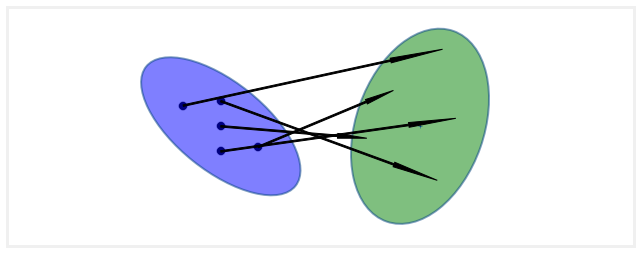

In [8]:
with book_format.figsize(10,4):
    ukf_internal.show_sigma_transform()

### Update Step

Now we can perform the update step of the filter. Recall that Kalman filters perform the update state in measurement space. So, the first thing we do is convert the sigma points from the predict step into measurements using the $h(x)$ function that you define.

$$\mathcal{X_z} = h(\mathcal{X})$$

Now we can compute the mean and covariance of these points using the unscented transform.

$$\begin{aligned}
\mathbf{x}_z &= \sum w\mathcal{X_z} \\
\mathbf{P}_z &= \sum w{(\mathcal{X_z}-x)(\mathcal{X_z}-x)^\mathsf{T}} + \mathbf{R}
\end{aligned}
$$

The $z$ subscript denotes that these are the mean and covariance for the measurements.

All that is left is to compute the residual and Kalman gain. The residual is trivial to compute:

$$ \mathbf{y} = \mathbf{z} - \mathbf{x}_z$$


The Kalman gain is not much worse. We have to compute the cross variance of the state and the measurements, which we state without proof to be: 

$$\mathbf{P}_{xz} =\sum W(\mathcal{X}-x)(\mathcal{X_z}-\mathbf{x}_z)^\mathsf{T}$$

And then the Kalman gain is defined as
$$K = \mathbf{P}_{xz} \mathbf{P}_z^{-1}$$

Finally, we compute the new state estimate using the residual and Kalman gain:

$$\hat{\mathbf{x}} = \mathbf{x}^- + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \mathbf{P} = \mathbf{P}^- - \mathbf{PKP}_z\mathbf{K}^\mathsf{T}$$

This step contains a few equations you have to take on faith, but you should be able to see how they relate to the linear Kalman filter equations. We convert the mean and covariance into measurement space, add the measurement error into the measurement covariance, compute the residual and kalman gain, compute the new state estimate as the old estimate plus the residual times the Kalman gain, and then convert both back into state space. The linear algebra is slightly different from the linear Kalman filter, but the algorithm is the same.

## Using the UKF

We are now ready to consider implementing a Kalman filter. All of the math is above is already implemented in FilterPy, and you are perhaps a bit lost at this point, so lets just launch into solving some problems so you can gain confidence in how easy the UKF actually is. Later we will revisit how the UKF is implemented in Python.


Let's start by solving a problem you already know how to do. Although the UKF was designed for nonlinear problems, it works fine on linear problems. We will write a solver for the linear problem of tracking using a constant velocity model in 2D. This will allows us to focus on what is the same (and most is the same!) and what is different with the UKF. 

To design a linear Kalman filter you need to design the $\bf{x}$, $\bf{F}$, $\bf{H}$, $\bf{R}$, and $\bf{Q}$ matrices. We have done this many times already so let me just present a design to you without a lot of comment. We want a constant velocity model, so we can define $\bf{x}$ to be

$$ \mathbf{x} = \begin{bmatrix}x \\  \dot{x} \\ y \\ \dot{y} \end{bmatrix}$$.

With this ordering of state variables we can define our state transition model to be

$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & 0 & 0 \\
0&1&0&0 \\
0&0&1&\Delta t\\
0&0&0&1
\end{bmatrix}$$

which implements the Newtonian equation

$$x_k = x_{k-1} + \dot{x}_{k-1}\Delta t$$

Our sensors provide position measurements but not velocity, so the measurement function is

$$\mathbf{H} = \begin{bmatrix}1&0&0&0 \\ 0&0&1&0
\end{bmatrix}$$

Let's say our our sensor gives positions in meters with an error of $1\sigma=0.3$ meters in both the *x* and *y* coordinates. This gives us a measurement noise matrix of 

$$\mathbf{R} = \begin{bmatrix}0.3^2 &0\\0 & 0.3^2\end{bmatrix}$$

Finally, let's assume that the process noise is discrete white noise model - that is, that over each time period the acceleration is constant. We can use `FilterPy`'s `Q_discrete_white_noise()` method to create this matrix for us, but for review the matrix is

$$\mathbf{Q} = \begin{bmatrix}
\frac{1}{4}\Delta t^4 & \frac{1}{2}\Delta t^3 \\
\frac{1}{2}\Delta t^3 & \Delta t^2\end{bmatrix} \sigma^2$$

Our implementation might look like this:

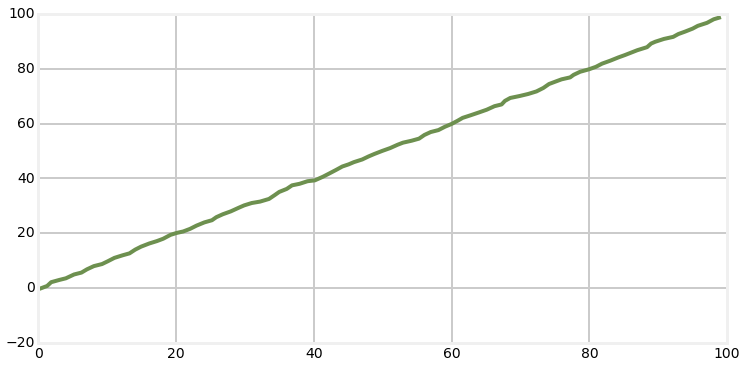

In [9]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy import random

dt = 1.0

random.seed(1234)
kf = KalmanFilter(4,2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([0.09, 0.09])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1,0,0,0],
                 [0,0,1,0]])
 
kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
kf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)
xs = []
zs = [] # save the zs so we use the same data for the UKF
for i in range(100):
    z = np.array([i+randn()*0.3, i+randn()*0.3])
    kf.predict()
    kf.update(z)
    xs.append(kf.x)
    zs.append(z)
    
xs = np.asarray(xs)
plt.plot(xs[:,0], xs[:,2])
plt.show()

This should hold no suprises for you. Now let's implement this filter as an Unscented Kalman filter. Again, this is purely for educational purposes; using a UKF for a linear filter confers no benefit.

The equations of the UKF are implemented for you with the `FilterPy` class `UnscentedKalmanFilter`; all you have to do is specify the matrices and the nonlinear functions *f(x)* and *h(x)*. *f(x)* implements the state transition function that is implemented by the matrix $\mathbf{F}$ in the linear filter, and *h(x)* implements the measurement function implemented with the matrix $\mathbf{H}$. In nonlinear problems these functions are nonlinear, so we cannot use matrices to specify them.

For our linear problem we can just define these functions to implement the linear equations. The function *f(x)* takes the signature `def f(x,dt)` and *h(x)* takes the signature `def h(x)`. Below is a reasonable implementation of these two functions. Each is expected to return a 1-D numpy array with the result.

In [10]:
def f_cv(x, dt):
    """ state transition function for a constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return np.dot(F, x)

def h_cv(x):
    return np.array([x[0], x[2]])

Other than these two functions, everything else is nearly the same. When you create the UKF you will pass in the two functions like so:

    from filterpy.kalman import UnscentedKalmanFilter as UKF
    ukf = UKF(dim_x=4, dim_z=2, fx=f, hx=h, dt=dt, kappa=0)

In [11]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, kappa=0)

The rest of the code is the same as for the linear kalman filter. Let's just implement it! I'll use the same measurements as used by the linear Kalman filter, and compute the standard deviation of the difference between the two solution.

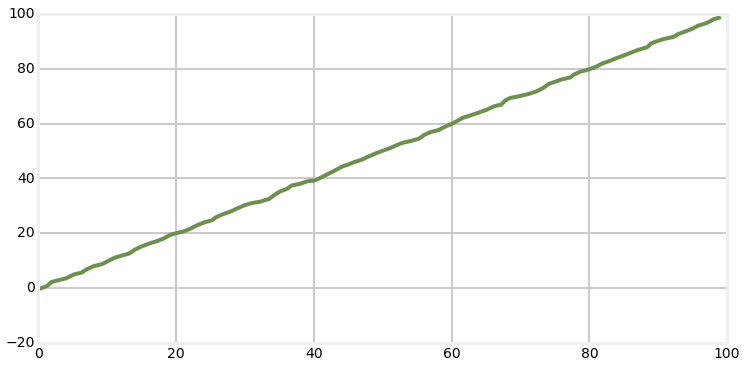

UKF standard deviation 0.013


In [12]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, kappa=0)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)
uxs = []
for i,z in enumerate(zs):
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
    
uxs = np.asarray(uxs)
plt.plot(uxs[:,0], uxs[:,2])
plt.show()
print('UKF standard deviation {:.3f}'.format(np.std(uxs-xs)))

This gave me a standard deviation 0f 0.013 which is quite small. 

You can see that there is not much difference in the implementation of the UKF vs linear Kalman filter. We merely replace $\mathbf{F}$ with the function *f(x)*, and the matrix $\mathbf{H}$ with the function *h(x)*. The rest of the theory and implementation remains the same. Well, of course under the hood the `FilterPy` implementation is quite different than the Kalman filter code, but from a designer's point of view the problem formulation and filter design is very similar.

## Tracking a Flying Airplane

### First Attempt

Let's tackle our first nonlinear problem. To minimize the number of things that change I will keep the problem formulation very similar to the linear tracking problem above. For this problem we will write a filter to track a flying airplane using a stationary radar as the sensor. To keep the problem as close to the previous one as possible we will track in two dimensions, not three. We will track one dimension on the ground and the altitude of the aircraft. The second dimension on the ground adds no difficulty or different information, so we can do this with no loss of generality.

 Radars work by emitting a beam of radio waves and scanning for a return bounce. Anything in the beam's path will reflects some of the signal back to the radar. By timing how long it takes for the reflected signal to get back to the radar the system can compute the *slant distance* - the straight line distance from the radar installation to the object. We also get the bearing to the target. For this 2D problem that will be the angle above the ground plane. True integration of sensors for applications like military radar and aircraft navigation systems have to take many factors into account which I am not currently interested in trying to cover in this book. So if any practioners in the the field are reading this they will be rightfully scoffing at my exposition. My only defense is to argue that I am not trying to teach you how to design a military grade radar tracking system, but instead trying to familarize you with the implementation of the UKF. 
 
For this example we want to take the slant range measurement from the radar and compute the horizontal position (distance of aircraft from the radar measured over the ground) and altitude of the aircraft, as in the diagram below.

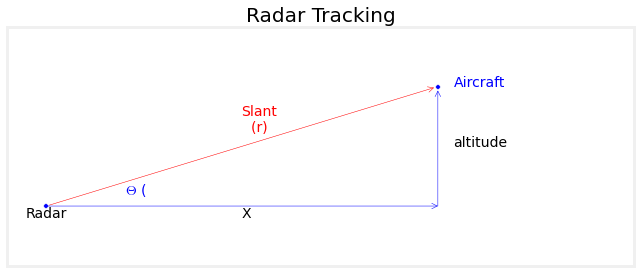

In [13]:
import ekf_internal
from contextlib import contextmanager

with book_format.figsize(10, 4):
    ekf_internal.show_radar_chart()

We will assume that the aircraft is flying at a constant altitude, so a three variable state vector will work.

$$\mathbf{x} = \begin{bmatrix}distance \\velocity\\ altitude\end{bmatrix}=  \begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix}$$

Our state transition function is linear 

$$\mathbf{x}^- = \begin{bmatrix} 1 & \Delta t & 0 \\ 0& 1& 0 \\ 0&0&1\end{bmatrix}
\begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix} 
$$

and we can implement that very much like we did for the previous problem.

In [14]:
def f_radar(x, dt):
    """ state transition function for a constant velocity aircraft
    with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return np.dot(F, x)

The next step is to design the measurement function. As in the linear Kalman filter the measurement function converts the filter's state into a measurement. So for this problem we need to position and velocity of the aircraft and convert it to the bearing and range from the radar station.

If we represent the position of the radar station with an (x,y) coordinate computation of the range and bearing is straightforward. To compute the range we use the Pythagorean theorem:

$$range = \sqrt{(x_{ac} - x_{radar})^2 + (z_{ac} - z_{radar})^2}$$

To compute the bearing we need to use the arctangent function.

$$bearing = \tan^{-1}{\frac{z_{ac} - z_{radar}}{x_{ac} - x_{radar}}}$$

As with the state transition function we need to define a Python function to compute this for the filter. I'll take advantage of the fact that a function can own a variable to store the radar's position.

In [15]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dz = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    bearing = math.atan2(dz, dx)
    return slant_range, bearing

h_radar.radar_pos = (0,0)

**Important Note**: There is a nonlinearity that we are not considering, the fact that angles are modular. Kalman filters operate by computing the differences between measurements. The difference between $359^\circ$ and $1^\circ$ is $2^\circ$, but a subtraction of the two values, as implemented by the filter, yields a value of $358^\circ$. This is exacerbated by the UKF which computes sums of weighted values in the unscented transform. For now we will place our sensors and targets in positions that avoid these nonlinear regions. Later in the chapter I will show you how to handle this problem.

We need to simulate the Radar station and the movement of the aircraft. By now this should be second nature for you, so I will present the code without much discussion.

In [16]:
from numpy.linalg import norm
from math import atan2

class RadarStation(object):
    
    def __init__(self, pos, range_std, bearing_std):
        self.pos = np.asarray(pos)
        
        self.range_std = range_std
        self.bearing_std = bearing_std

    
    def reading_of(self, ac_pos):
        """ Returns actual range and bearing to aircraft as tuple. 
        Bearing is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and bearing to aircraft with simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.bearing_std 
        return rng, brg
        
   
class ACSim(object):
    
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std
        
        
    def update(self, dt):
        """ compute next position. Incorporates random variation in
        velocity. Returns new position."""
        
        vel = self.vel*dt + (randn() * self.vel_std)*dt      
        self.pos += vel
        
        return self.pos

Now let's put it all together. A military grade radar system can achieve 1 meter RMS range accuracy, and 1 mrad RMS for bearing [1]. We will assume a more modest 5 meter range accuracy, and 0.5$^\circ$ anglular accuracy as this provides a more challenging data set for the filter.

I'll start with the aircraft positioned directly over the radar station, flying away from it at 100 m/s. A typical radar might update only once every 12 seconds and so we will use that for our update period. 

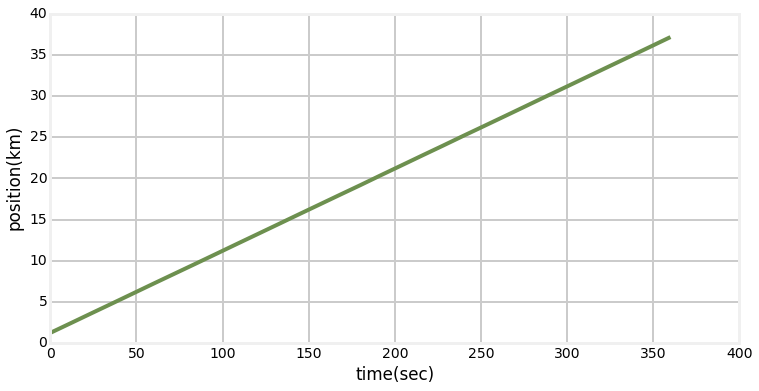

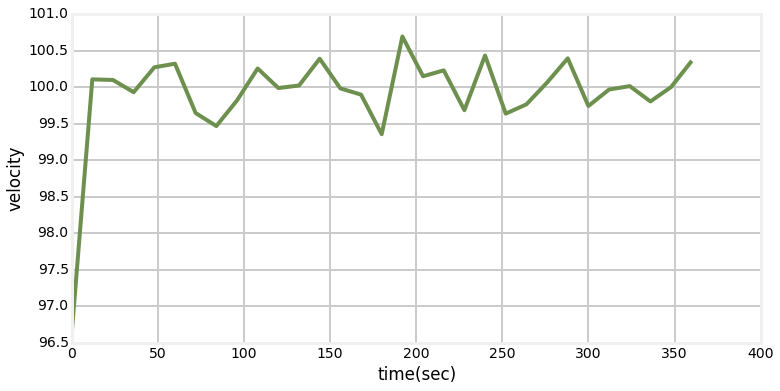

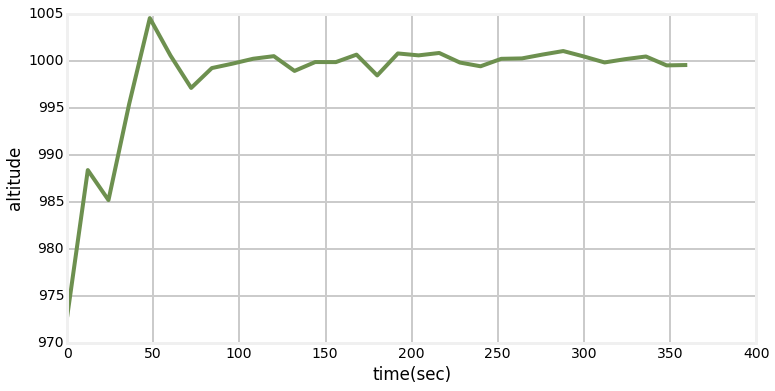

In [17]:
import math

from filterpy.common import Q_discrete_white_noise

dt = 12. # 12 seconds between readings

range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, kappa=0.)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2,2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])


radar = RadarStation(pos=(0,0), range_std=range_std, bearing_std=bearing_std)
ac = ACSim(ac_pos, (100,0), 0.02)

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)
   
def plot_radar(xs, t, plot_x=True, plot_vel=True, plot_alt=True):
    
    xs = np.asarray(xs)
    if plot_x:
        plt.figure()
        plt.plot(t, xs[:,0]/1000.)
        plt.xlabel('time(sec)')
        plt.ylabel('position(km)')
        
    if plot_vel:
        plt.figure()
        plt.plot(t, xs[:,1])
        plt.xlabel('time(sec)')
        plt.ylabel('velocity')

    if plot_alt:
        plt.figure()
        plt.plot(t, xs[:,2])
        plt.xlabel('time(sec)')
        plt.ylabel('altitude')
        plt.show()
    
plot_radar(xs, t)

This may or may not impress you, but it impresses me. In the Extended Kalman filter chapter we will solve the same problem, but it will take significant amounts of mathematics to handle the same problem. 

### Tracking Manuevering Aircraft

The previous example produced extremely good results, but it also relied on an assumption of an aircraft flying at a constant speed with no change in altitude. I will relax that assumption by allowing the aircraft to change altitude. First, let's see the performance of the previous code if the aircraft starts climbing after one minute.

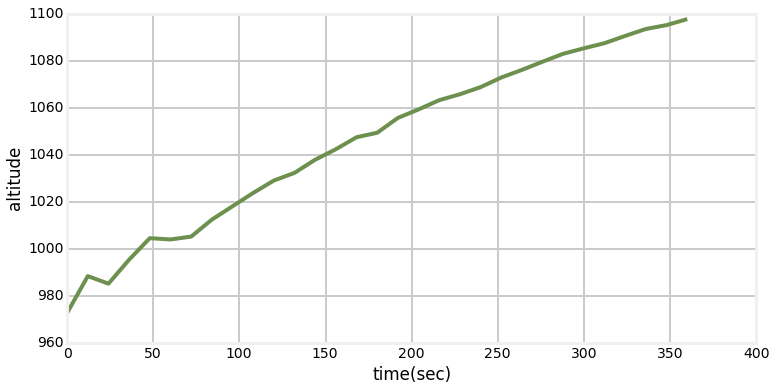

Actual altitude: 2561.9
UKF altitude   : 1097.9


In [18]:
# reset aircraft position
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])
ac = ACSim(ac_pos, (100,0), 0.02)

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in t:
    if i >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_radar(xs, t, plot_x=False, plot_vel=False, plot_alt=True)
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude   : {:.1f}'.format(xs[-1][2]))

the performance is terrible as the filter is completely unable to track the changing altitude. What do we have to change to allow the filter to track the aircraft?

I hope you answered add climb rate to the state, like so:


$$\mathbf{x} = \begin{bmatrix}distance \\velocity\\ altitude \\ climb rate\end{bmatrix}=  \begin{bmatrix}x \\\dot{x}\\ z \\ \dot{z}\end{bmatrix}$$

This requires the following change to the state transition function, which is still linear.


$$\mathbf{x}^- = \begin{bmatrix} 1 & \Delta t & 0 &0 \\ 0& 1& 0 &0\\ 0&0&1&dt \\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\\dot{x}\\ z\\ \dot{z}\end{bmatrix} 
$$
The measurement function stays the same, but we will have to alter Q to account for the state dimensionality change.

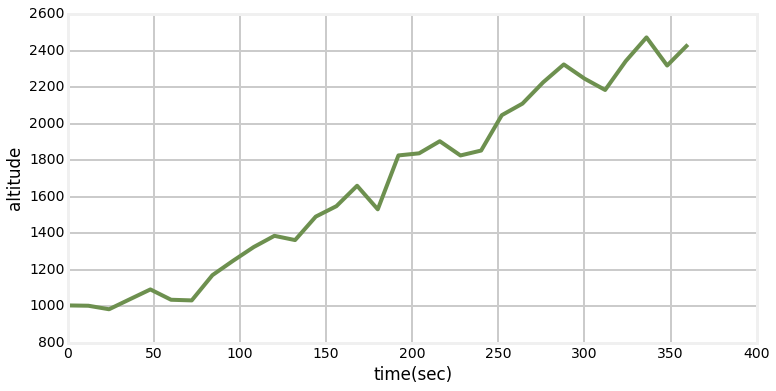

Actual altitude: 2561.9
UKF altitude   : 2432.9


In [19]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity aircraft"""
    
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return np.dot(F, x)

ac = ACSim(ac_pos, (100,0), 0.02)

kf = UKF(4, 2, dt, fx=f_cv_radar, hx=h_radar, kappa=-1)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in t:
    if i >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_radar(xs, t, plot_x=False, plot_vel=False, plot_alt=True)
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude   : {:.1f}'.format(xs[-1][2]))

We can see that a significant amount of noise has been introduced into the altitude, but we are now accurately tracking the altitude change. 

### Sensor Fusion

Now let's consider a simple example of sensor fusion. Suppose we have some type of doppler system that produces a velocity estimate with 2 m/s RMS accuracy. I say "some type" because as with the radar I am not trying to teach you how to create an accurate filter for a doppler system, where you have to account for the signal to noise ratio, atmospheric effects, the geometry of the system, and so on. 

The accuracy of the radar system in the last examples allowed us to estimate velocities to withn a m/s or so, so we have to degrade that accuracy to be able to easily see the effect of the sensor fusion. Let's change the range error to 500 meters and then compute the standard deviation of the computed velocity. I'll skip the first several measurements because the filter is converging during that time, causing artificially large deviations.

Velocity standard deviation 3.5 m/s


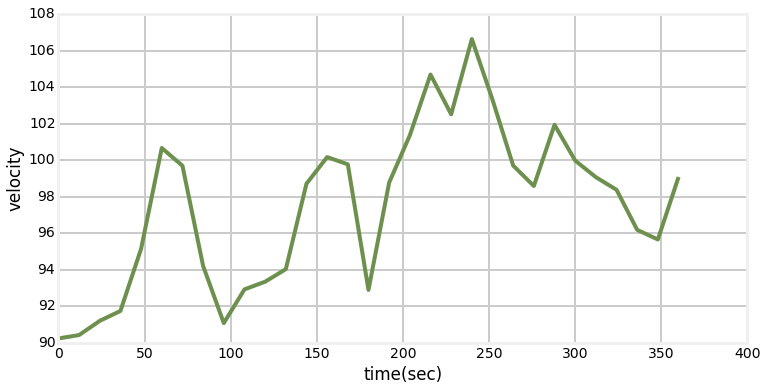

In [20]:
range_std = 500.
bearing_std = math.degrees(0.5)
radar = RadarStation(pos=(0,0), range_std=range_std, bearing_std=bearing_std)

ac = ACSim(ac_pos, (100,0), 0.02)
kf = UKF(4, 2, dt, fx=f_cv_radar, hx=h_radar, kappa=0.)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in t:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

xs = np.asarray(xs)
plot_radar(xs, t, plot_x=False, plot_vel=True, plot_alt=False)
print('Velocity standard deviation {:.1f} m/s'.format(np.std(xs[10:,1])))

Velocity standard deviation 1.3 m/s


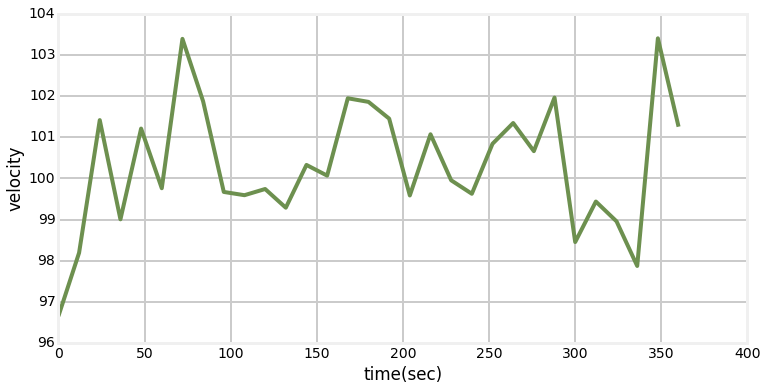

In [21]:
def h_vel(x):
    dx = x[0] - h_vel.radar_pos[0]
    dz = x[2] - h_vel.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    bearing = math.atan2(dz, dx)
    return slant_range, bearing, x[1], x[3]

h_vel.radar_pos = (0,0)

range_std = 500.
bearing_std = math.degrees(0.5)
radar = RadarStation(pos=(0,0), range_std=range_std, bearing_std=bearing_std)
vel_std = 2.

ac = ACSim(ac_pos, (100,0), 0.02)
kf = UKF(4, 4, dt, fx=f_cv_radar, hx=h_vel, kappa=0.)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2, vel_std**2, vel_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in t:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    vx = ac.vel[0] + randn()*vel_std
    vz = ac.vel[1] + randn()*vel_std
    kf.predict()
    kf.update([r[0], r[1], vx, vz]) 
    xs.append(kf.x)
xs = np.asarray(xs)
plot_radar(xs, t, plot_x=False, plot_vel=True, plot_alt=False)
print('Velocity standard deviation {:.1f} m/s'.format(np.std(xs[10:,1])))

By incorporating the velocity sensor we were able to reduce the standard deviation from 3.5 m/s to 1.3 m/s. 

Sensor fusion is a large topic, and this is a rather simplistic implementation. In a typical navigation problem we have sensors that provide *complementary* information. For example, a GPS might provide somewhat accurate position updates once a second with poor velocity estimation while an inertial system might provide very accurate velocity updates at 50Hz but terrible position estimates. The strenghs and weaknesses of each sensor are orthoganol to each other. This leads to something called the *Complementary filter*, which uses the high update rate of the inertial sensor with the position accurate but slow estimates of the GPS to produce very high rate yet very accurate position and velocity estimates. This will be the topic of a future chapter. 

### Multiple Position Sensors

The last sensor fusion problem was somewhat a toy example due to the existence of techniques like the *Complementary filter*. Let's tackle a problem that is not so toy-like. Before the advent of GPS ships and aircraft navigated via various range and bearing systems such as VOR, LORAN, TACAN, DME, and so on. I do not intend to cover the intricacies of these systems - Wikipedia will fill the basics if you are interested. In general these systems are beacons that allow you to extract either the range, bearing, or range and bearing to the beacon. For example, an aircraft might have two VOR receivers. The pilot tunes each receiver to a different VOR station. Each VOR receiver displays what is called the "radial" - the direction from the VOR station on the ground to the aircraft. Using a chart they can extend these two radials - the intersection point is the position of the aircraft.

That is a very manual and low accuracy approach. We can use a Kalman filter to filter the data and produce far more accurate position estimates. Let's work through that.

The problem is as follows. Assume we have two sensors, each which provides a bearing only measurement to the target, as in the chart below. In the chart the width of the circle is intended to denote a different amount of sensor noise.

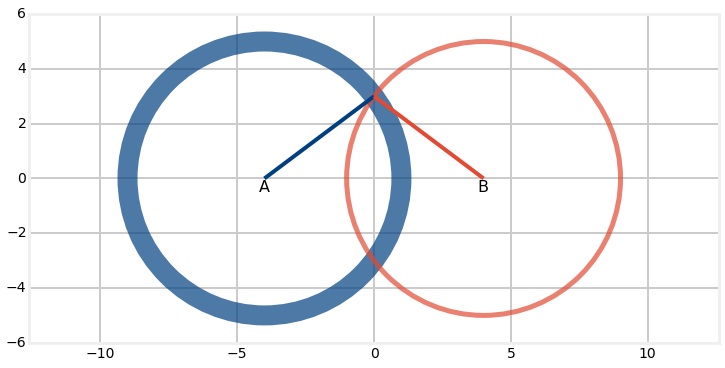

In [22]:
ukf_internal.show_two_sensor_bearing()

We can compute the bearing between a sensor and the target as follows:

    def bearing(sensor, target):
        return math.atan2(target[1] - sensor[1], target[0] - sensor[0])

So our filter will need to receive a vector of 2 measurements during each update, one for each sensor. We can implement that as:

    def measurement(A_pos, B_pos, pos):
        angle_a = bearing(A_pos, pos)
        angle_b = bearing(B_pos, pos)
        return [angle_a, angle_b]

The design of the measurement function and state transition function can remain the same as nothing has changed that would affect them. 

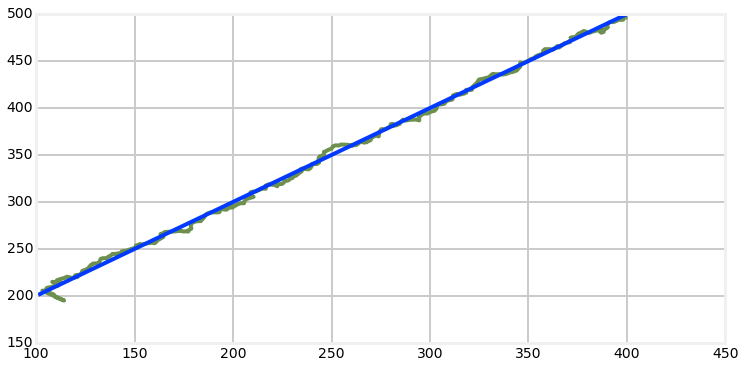

In [23]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise

sa_pos = [-400, 0]
sb_pos = [400, 0]


def bearing(sensor, target_pos):
    return math.atan2(target_pos[1] - sensor[1], target_pos[0] - sensor[0])

def measurement(A_pos, B_pos, pos):
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

def fx_VOR(x,dt):
    x[0] += x[1]
    x[2] += x[3]
    return x


def hx_VOR(x):
    # measurement to A
    pos = (x[0], x[2])
    return measurement(sa_pos, sb_pos, pos)


def moving_target_filter(target_pos, std_noise, Q, dt=0.1, kappa=0.0):
    f = UKF(dim_x=4, dim_z=2, dt=dt, hx=hx_VOR, fx=fx_VOR, kappa=kappa)
    f.x = np.array([target_pos[0], 1., target_pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2,0:2] = q
    f.Q[2:4, 2:4] = q

    f.R *= std_noise**2
    f.P *= 1000
    
    return f


def plot_straight_line_target(f, std_noise):
    xs = []
    txs = []

    for i in range(300):
        target_pos[0] += 1 + randn()*0.0001
        target_pos[1] += 1 + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:,0], xs[:,2])
    plt.plot(txs[:,0], txs[:,1])
    plt.show()
 
np.random.seed(123)
target_pos = [100, 200]

std_noise = math.radians(0.5)
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

This looks quite good to me. There is a very large error at the beginning of the track, but the filter is able to settle down and start producing good data.

Let's revisit the nonlinearity of the angles. I will position the target between the two sensors with the same y-coordinate. This will cause a nonlinearity in the computation of the sigma means and the residuals because the mean angle will be near zero. As the angle goes below 0 the measurement function will compute a large positive angle of around $2\pi$. The residual between the prediction and measurement will thus be very large, nearly $2\pi$ instead of nearly 0. This makes it impossible for the filter to perform accurately, as seen in the example below.

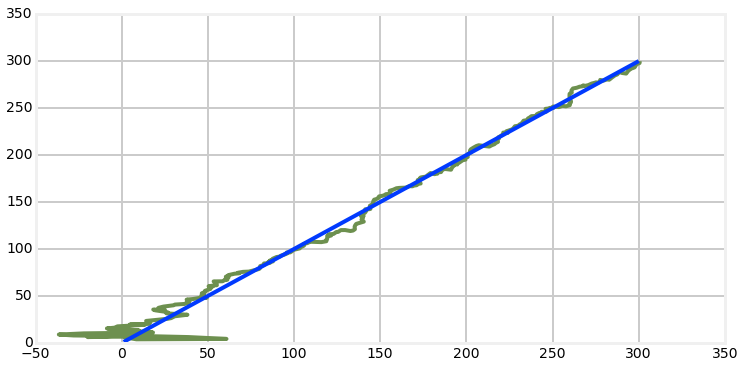

In [24]:
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

This is untenable behavior for a real world filter. `FilterPy`'s UKF code allows you to provide it a function to compute the residuals in cases of nonlinear behavior like this, but this requires more knowledge about `FilterPy`'s implementation than we yet process.

Finally, let's discuss the sensfor fusion method that we used. We used the measurement from each bearing and had the Kalman filter's equations compute the world position from the measurements. This is equivalent to doing a weighted least squares solution. In the *Kalman Filter Math* chapter we discussed the limited accuracy of such a scheme and introduced an *Iterative Least Squares* (ILS) algorithm to produce greater accuracy. If you wanted to use that scheme you would write an ILS algorithm to solve the geometry of your problem, and pass the result of that calculation into the `update()` method as the measurement to be filtered. This imposes on you the need to compute the correct noise matrix for this computed positions, which may not be trivial. Perhaps in a later release of this book I will develop an example, but regardless it will take you a significant amount of research and experiment to design the best method for your application. For example, the ILS is probably the most common algorithm used to turn GPS pseudoranges into a position, but the literature discusses a number of alternatives. Sometimes there are faster methods, sometimes the iterative method does not converge, or does not converge fast enough, or requires too much computation for an embedded system. 

## Exercise: Track a target moving in a circle

Change the simulated target movement to move in a circle. Avoid angular nonlinearities by putting the sensors well outside the movement range of the target, and avoid the angles $0^\circ$ and $180^\circ$.

In [25]:
# your solution here

### Solution

We have a few choices here. First, if we know the movement of the target we can design our filter's state transition function so that it correctly predicts the circular movement. For example, suppose we were tracking a boat race optically - we would want to take track shape into account with our filter. However, in this chapter we have not been talking about such constrained behavior, so I will not build knowledge of the movement into the filter. So my implementation looks like this.

In [26]:
def plot_circular_target(f, std_noise, target_pos):
    xs = []
    txs = []
    radius = 100
    for i in range(300):
        target_pos[0] = math.cos(i/10)*radius + randn()*0.0001
        target_pos[1] = math.sin(i/10)*radius + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:,0], xs[:,2])
    plt.plot(txs[:,0], txs[:,1], linestyle='-.')
    plt.axis('equal')
    plt.show()

sa_pos = [-240, 200]
sb_pos = [240, 200]

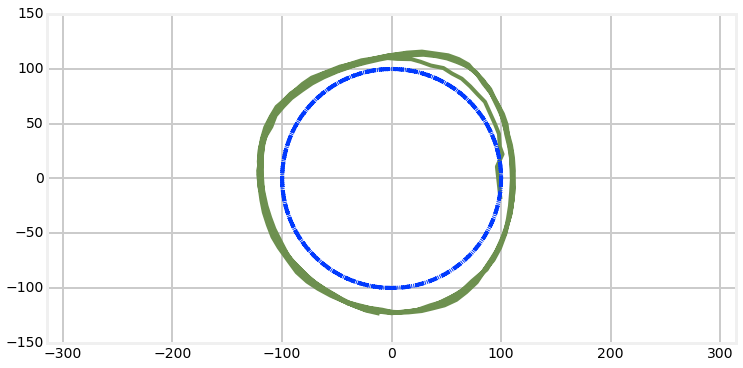

In [27]:
np.random.seed(12283)
std_noise = math.radians(0.5)
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.1)
plot_circular_target(f, std_noise, target_pos)

### Discussion

The filter tracks the movement of the target, but never really converges on the track.  This is because the filter is modeling a constant velocity target, but the target is anything but constant velocity. As mentioned above we could model the circular behavior by defining the `fx()` function, but then we would have problems when the target is not moving in a circle. Instead, lets tell the filter we are are less sure about our process model by making $\mathbf{Q}$ larger. Here I have increased the variance from 0.1 to 1.0

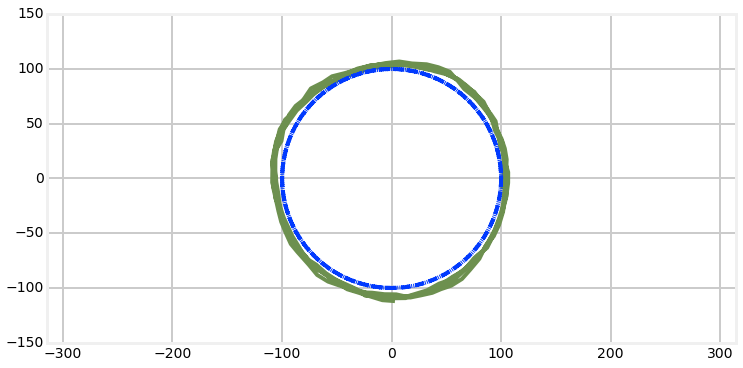

In [28]:
np.random.seed(12283)
std_noise = math.radians(0.5)
cf = moving_target_filter(target_pos, std_noise, Q=10.)
target_pos = [0, 0]
plot_circular_target(cf, std_noise, target_pos)

The convergence is not perfect, but it is far better. 

## Exercise: Sensor Position Effects

Is the behavior of the filter invariant for any sensor position? Find a sensor position that produces bad filter behavior.

In [29]:
# your answer here

### Solution

We have already discussed the problem of angles being modal, so causing that problem by putting the sensors at `y=0` would be a trivial solution. However, let's be more subtle than that. We want to create a situation where there are an infinite number of solutions for the sensor readings. We can achieve that whenever the target lies on the straight line between the two sensors. In that case there is no triangulation possible and there is no unique solution. My solution is as follows.

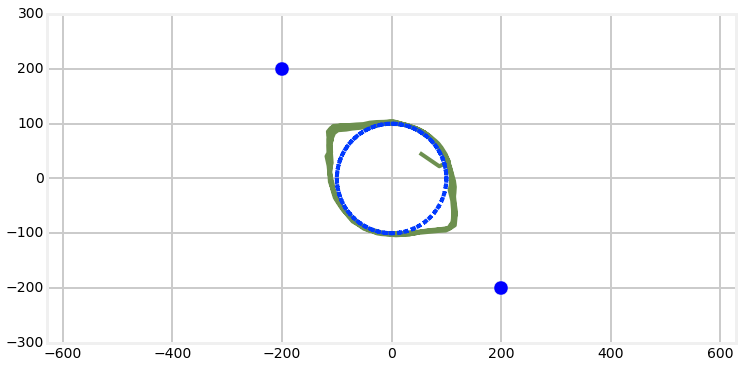

In [30]:
std_noise = math.radians(0.5)
sa_pos = [-200,200]
sb_pos = [200,-200]
plt.scatter(*sa_pos, s=200)
plt.scatter(*sb_pos, s=200)
target_pos = [0, 0]
cf = moving_target_filter(target_pos, std_noise, Q=10.)
plot_circular_target(cf, std_noise, target_pos)

I put the sensors at the upper left hand side and lower right hand side of the target's movement. We can see how the filter diverges when the target enters the region directly between the two sensors. The state transition always predicts that the target is moving in a straight line. When the target is between the two sensors this straight line movement is well described the bearing measurements from the two sensors so the filter estimate starts to approximate a straight line. 

## Exercise: Compute Position Errors

The position errors of the filter vary depending on how far away the target is from a sensor. Write a function that computes the distance error due to a bearing error. 

In [31]:
# your solution here

### Solution

Basic trigonometry gives us this answer.

In [32]:
def distance_error(target_distance, angle_error):
    x = 1-math.cos(angle_error)
    y = math.sin(angle_error)
    return target_distance*(x**2 + y**2)**.5

d = distance_error(100, math.radians(1.))
print('\n\nError of 1 degree at 100km is {:.3}km'.format(d))



Error of 1 degree at 100km is 1.75km


### Discussion

This is an inherent physical limitation that is extremely difficult to deal with when designing filters. We can see that a very small angular error translates into a very large distance error. What is worse, this behavior is nonlinear - the error in the *x-axis* vs the *y-axis* will vary depending on the actual bearing. For example, here is a scatter plot that shows the error distribution for a $1^\circ$ standard deviation in bearing for a $30^\circ$ bearing.

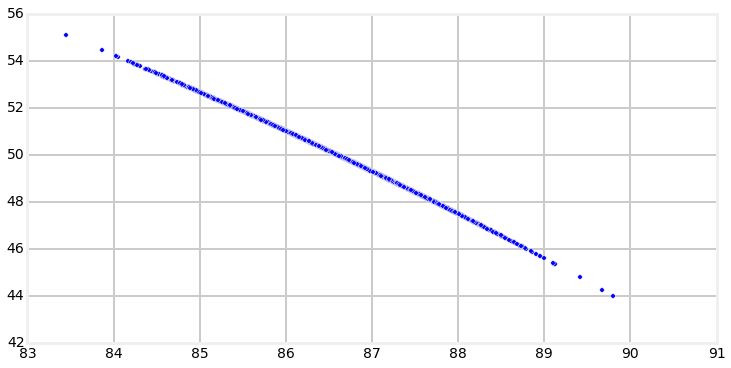

In [33]:
d = 100
xs, ys = [], []

for i in range (3000):
    a = math.radians(30) + randn() * math.radians(1)
    
    xs.append(d*math.cos(a))
    ys.append(d*math.sin(a))
    
plt.scatter(xs, ys)
plt.show() 

## Exercise: Explain Filter Performance

We can see that for even very small angular errors the (x, y) positional errors are very large. Explain how we got such relatively good performance out of the UKF in the target tracking problems above. Answer this for the one sensor problem as well as the multiple sensor problem. 

### Solution

> This is **very** important to understand. Try very hard to answer this before reading the answer below. If you cannot answer this you really need to revisit some of the earlier Kalman filter material in the Multidimensional Kalman filter chapter.

There are several factors contributing to our success. First, let's consider the case of having only one sensor. Any single measurement has an extreme range of possible positions. But, our target is moving, and the UKF is taking that into account. Let's plot the results of several measurements taken in a row for a moving target to form an intuition.

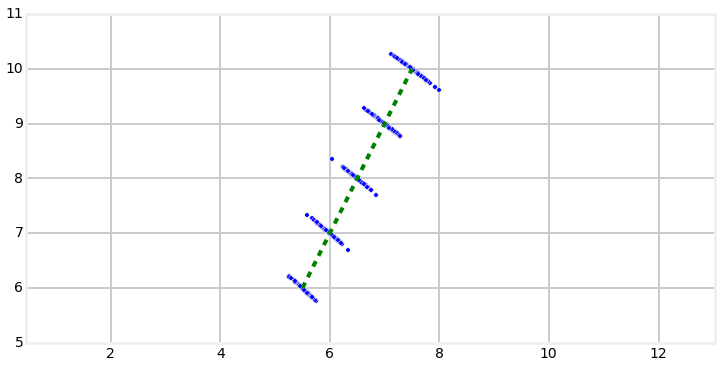

In [34]:
pos = [5, 5]
for i in range(5):
    pos[0] += 0.5
    pos[1] += 1  
    
    actual_angle = math.atan2(pos[1], pos[0])
    d = math.sqrt(pos[0]**2 + pos[1]**2)

    xs, ys = [], []
    for i in range (100):
        a = actual_angle + randn() * math.radians(1)
        xs.append(d*math.cos(a))
        ys.append(d*math.sin(a))
    plt.scatter(xs, ys)

plt.axis('equal')
plt.plot([5.5, pos[0]], [6, pos[1]], c='g', linestyle='--')
plt.show()

We can see that each individual measurement has a very large position error. However, when we plot successive measurements we suddenly have a clear trend - the target is obviously moving towards the upper right. When the Kalman filter (whether a linear KF, an EKF, or UKF) computes the Kalman gain it takes the distribution of errors into account by using the measurement function. In this example the error lies on an approximately $45^\circ$ degree line, so the filter will discount errors in that direction. On the other hand, there is almost no error in measurement orthogonal to that, and again the Kalman gain will be taking that into account. The end result is the track can be computed even with this sort of noise distribution. Of course, this graph makes it look easy because we have computed 100 possible measurements for each position update and plotted them all. This makes it easy for us to see where the target is moving. In contrast, the Kalman filter only gets 1 measurement per update. Therefore the filter will not be able to generate as good a fit as the dotted green line implies. 

The next interaction we must think about is the fact that the bearing gives us no distance information. Suppose in the example above we told the filter that the initial position of the target was 1000km away from the sensor (vs the actual distance of 7.07 km), and that we were highly confident in that guess by setting $\mathbf{P}$ very small. At that distance a $1^\circ$ error translates into a positional error of 17.5 km. The KF would never be able to converge onto the actual target position because the filter is incorrectly very certain about its position estimates and because there is no distance information provided in the measurements.

Now let's consider the effect of adding a second sensor. Again, I will start by plotting the measurements so we can form an intuition about the problem.

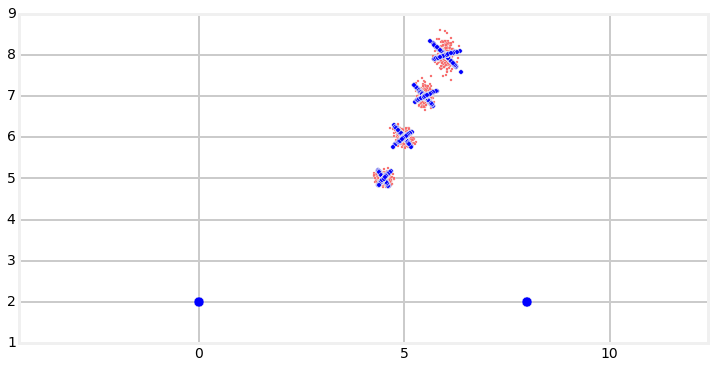

In [35]:
from math import sin, cos, atan2, pi

def isct(pa, pb, alpha, beta):
    """ Returns the (x, y) intersections of points pa and pb
    given the bearing ba for point pa and bearing bb for
    point pb.
    """
    
    B = [pb[0] - pa[0], pb[1]- pa[1]]

    AB = math.sqrt((pa[0]-pb[0])**2 + (pa[1] - pb[1])**2) 
    
    ab = atan2(B[1], B[0])
    a = alpha - ab    
    b = pi - beta - ab
    p = pi - b - a
    
    AP = (sin(b) / sin(p)) * AB
    
    x = cos(alpha) * AP + pa[0]
    y = sin(alpha) * AP + pa[1]
    return x, y


def plot_iscts(N=4):
    for i in range(N):
        pos[0] += 0.5
        pos[1] += 1  

        actual_angle_a = math.atan2(pos[1]-sa[1], pos[0] - sa[0])
        actual_angle_b = math.atan2(pos[1]-sb[1], pos[0] - sb[0])

        da = math.sqrt((sa[0]-pos[0])**2 + (sa[1]-pos[1])**2)
        db = math.sqrt((sb[0]-pos[0])**2 + (sb[1]-pos[1])**2)

        xs, ys, xs_a, xs_b, ys_a, ys_b = [], [], [], [], [], []

        for i in range (300):
            a_a = actual_angle_a + randn() * math.radians(1)
            a_b = actual_angle_b + randn() * math.radians(1)

            x,y = isct(sa, sb, a_a, a_b)
            xs.append(x)
            ys.append(y)

            xs_a.append(da*math.cos(a_a)+sa[0])
            ys_a.append(da*math.sin(a_a)+sa[1])

            xs_b.append(db*math.cos(a_b)+sb[0])
            ys_b.append(db*math.sin(a_b)+sb[1])

        plt.scatter(xs, ys, c='r', marker='.')
        plt.scatter(xs_a, ys_a)
        plt.scatter(xs_b, ys_b)

    plt.axis('equal')
    plt.show()

pos = [4, 4]
sa = [0, 2]
sb = [8, 2]

plt.scatter(*sa, s=100)
plt.scatter(*sb, s=100)
plot_iscts(N=4)

I placed the sensors nearly orthogonal to the target's initial position so we get these lovely 'x' shape intersections. I then computed the (x, y) coordinate corresponding to the two noisy bearing measurements and plotted them with red dots to show the distribution of the noisy measurements in x and y. We can see how the errors in x and y change as the target moves by the shape the scattered red dots make - as the target gets further away from the sensors, but nearer the y coordinate of sensor B the shape becomes strongly elliptical.

Next I will alter the starting positions and rerun the simulation. Here the shape of the errors in x and y changes radically as the target position changes relative to the two sensors. 

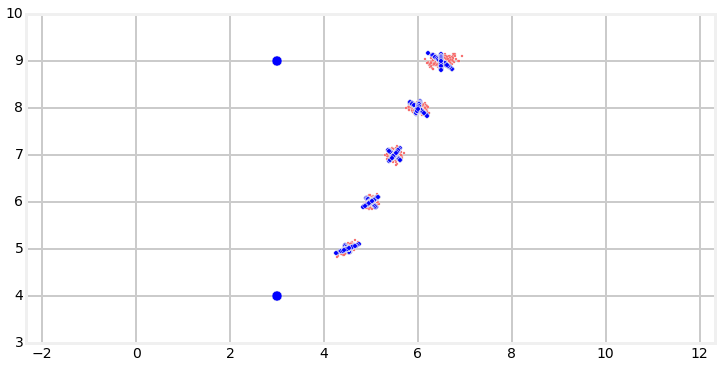

In [36]:
sa = [3, 4]
sb = [3, 9]
pos= [4, 4]

plt.scatter(*sa, s=100)
plt.scatter(*sb, s=100)
plot_iscts(N=5)

## Exercise: Visualize Sigma Points

Early in the chapter you were asked to pass points through a nonlinear function and to plot the mean. Use the UKF to generate sigma points and pass them through the nonlinear function, and plot the sigma points and their mean against the 5,000 points.

Pass the points through the state transition function:

$$\mathbf{Fx} = \begin{bmatrix}1 & 1 \\ .1x &y\end{bmatrix}\begin{bmatrix}x\\y\end{bmatrix}$$ 

for the mean $$\mu = \begin{bmatrix}0\\0\end{bmatrix}$$ and the covariance
$$\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

In [37]:
# Your solution here

### Solution

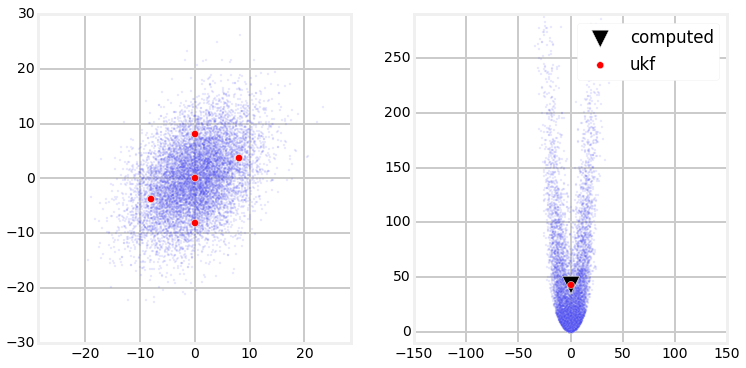

Difference in mean x=0.083, y=-0.215


In [38]:
from filterpy.kalman import unscented_transform

def f_nonlinear_xy(x,y):
    return np.array([x+y, .1*x**2 +y*y])

mean = (0, 0)
p = np.array([[32., 15],
              [15., 40.]])


### compute mean via UKF
kappa = 0.
w = UKF.weights(2, kappa)
sigmas = UKF.sigma_points(mean, p, kappa)
sigmas_f = np.zeros((5,2))
for i in range(5):
        sigmas_f[i] = f_nonlinear_xy(sigmas[i,0], sigmas[i,1])
  

ukf_mean, _ = unscented_transform(sigmas_f, w, w, np.zeros((2,2)))

# generate 500000 points to compute accurate mean
np.random.seed(73291)
xs ,ys = multivariate_normal(mean=mean, cov=p, size=10000).T
fxs, fys = [], []
for x,y in zip(xs,ys):
    fx, fy = f_nonlinear_xy(x,y)
    
    fxs.append(fx)
    fys.append(fy)

computed_mean_x = np.average(fxs)
computed_mean_y = np.average(fys)


plt.subplot(121)
plt.scatter (xs[0:10000], ys[0:10000], marker='.', alpha=0.1)
plt.scatter(sigmas[:,0], sigmas[:,1], c='r',s=50)
plt.axis('equal')

plt.subplot(122)
plt.scatter(fxs[0:10000], fys[0:10000], marker='.', alpha=0.1)
plt.scatter(computed_mean_x, computed_mean_y, 
            marker='v',s=300,c='k', label='computed')
plt.scatter(ukf_mean[0], ukf_mean[1], 
            marker='o', s=50, c='r', label='ukf')
plt.ylim([-10,290])
plt.xlim([-150,150])
plt.legend(loc='best', scatterpoints=1)
plt.show()
print ('Difference in mean x={:.3f}, y={:.3f}'.format(
       computed_mean_x-ukf_mean[0], computed_mean_y-ukf_mean[1]))

### Discussion

The first exercise had an error of roughly 43 in the y axis, whereas with 10,000,000 points simulated the UKF has an error of around 0.03. It is very likely that a larger number is displayed above, but that is because I set the number of points to 10,000 so the cell will run quickly for you. I find this result very astonishing - using only 5 points the UKF generates a better estimate than using 5000 points with a naive algorithm. 

## Implementation of the UKF

Implementing the UKF is quite straightforward. First, let's write the code to compute the mean and covariance given the sigma points. 

We will store the sigma points and weights in matrices, like so:

$$ 
\begin{aligned}
weights &= 
\begin{bmatrix}
w_1&w_2& \dots & w_{2n+1}
\end{bmatrix} 
\\
sigmas &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} &  \mathcal{X}_{0,2} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \mathcal{X}_{1,2} \\
\vdots & \vdots & \vdots \\
\mathcal{X}_{2n+1,0} & \mathcal{X}_{2n+1,1} & \mathcal{X}_{2n+1,2}
\end{bmatrix} \\
sigmas &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} &  \mathcal{X}_{0,2n+1} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \mathcal{X}_{1,2n+1} \\
\vdots & \vdots & \vdots \\
\mathcal{X}_{D-1,0} & \mathcal{X}_{D-1,1} & \mathcal{X}_{D-1,2n+1}
\end{bmatrix}
\end{aligned}
$$

In other words, each column contains the $2n+1$ sigma points for one dimension in our problem. The $0th$ sigma point is always the mean, so first row of sigma's contains the mean of each of our dimensions. The second through nth row contains the $\mu+\sqrt{(n+\lambda)\Sigma}$ terms, and the $n+1$ to $2n$ rows contains the $\mu-\sqrt{(n+\lambda)\Sigma}$ terms. the choice to store the sigmas in row-column vs column row format is somewhat arbitrary; my choice makes the rest of the code a bit easier to code as I can refer to the ith sigma point for all dimensions as `sigmas[i]`.

### Weights

Computing the weights in numpy is extremely simple. Recall that for the Julier implementation

$$
\begin{aligned}
W_0 &= \frac{\kappa}{n+\kappa} \\
W_i &= \frac{1}{2(n+\kappa)}\,\,\,\text{for i=1,2..2n}
\end{aligned}
$$

These two lines of code implement these equations with the `np.full()` method, which creates and fills an array with the same value. Then the value for the mean($W_0$) is computed and overwrites the filled in value. 

    W = np.full((2*n+1,1), .5 / (n+kappa))
    W[0] = kappa / (n+kappa)
    
Our final function will look something like this.

In [39]:
def weights(n, kappa):
    """ Computes the weights for an unscented Kalman filter. """

    k = .5 / (n+kappa)
    W = np.full(2*n+1, k)
    W[0] = kappa / (n+kappa)
    return W

### Sigma Points

The equations for the sigma points are:

$$
\begin{aligned}
\mathcal{X}_0 &= \mu \\
\mathcal{X}_i &= \mu +  \bigg[\sqrt{(n+\kappa)\Sigma}  \bigg]_i\,\,\,\, &\text{for}\text{ i=1 .. n} \\
\mathcal{X}_i &= \mu - \bigg[\sqrt{(n+\kappa)\Sigma}\bigg]_{i-n}\,\,\,\,\, &\text{for}\text{ i=(n+1) .. 2n}
\end{aligned}
$$


The Python for this is not much more difficult once we wrap our heads around the $[\sqrt{(n+\kappa)\Sigma}]_i$ term.

The term $[\sqrt{(n+\kappa)\Sigma}]_i$ has to be a matrix because $\Sigma$ is a matrix. The subscript $i$ is choosing the column vector of the matrix. What is the 'square root of a matrix'? The usual definition is that the square root of a matrix $\Sigma$ is just the matrix $S$ that, when multiplied by itself, yields $\Sigma$.

$$
\begin{aligned}
\text{if }\Sigma = SS \\
\\
\text{then }S = \sqrt{\Sigma}
\end{aligned}
$$

However there is an alternative definition, and we will chose that because it has numerical properties that makes it much easier for us to compute its value. We can alternatively define the square root as the matrix S, which when multiplied by its transpose, returns $\Sigma$:

$$
\Sigma = SS^\mathsf{T} \\
$$

This latter method is typically chosen in computational linear algebra because this expression is easy to compute using something called the *Cholesky decomposition* [3]. 
NumPy provides this with the `numpy.linalg.cholesky()` method. If your language of choice is Fortran, C, C++, or the like standard libraries such as LAPACK also provide this routine. And, of course, Matlab provides `chol()`, which does the same thing.

This method returns a lower triangular matrix, so we will take the transpose of it so that in our for loop we can access it row-wise as `U[i]`, rather than the more cumbersome column-wise notation `U[i,:]`.

    Sigmas = np.zeros((2*n+1, n))
    U = linalg.cholesky((n+kappa)*P).T

    for k in range (n):
        Sigmas[k+1]   = X + U[k]
        Sigmas[n+k+1] = X - U[k]

    Sigmas[0] = X

Now let's implement the unscented transform. Recall the equations
$$\begin{aligned}
\mu &= \sum_i w_i\mathcal{X}_i\;\;\;&(2) \\
\Sigma &= \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}\;\;\;&(3)
\end{aligned}
$$

The scaled UKF uses different weights for the means and covariance, so we will use the variable `Wm` for the mean weights and `Wc` for the covariance weights.

We implement the sum of the means with

    X = np.dot (Wm, Sigmas)

If you are not a heavy user of NumPy this may look foreign to you. NumPy is not just a library that make linear algebra possible; under the hood it is written in C to achieve much faster speeds than Python can reach. A typical speedup is 100x. To get that speedup we must avoid using for loops, and instead use NumPy's built in functions to perform calculations. So, instead of writing a for loop to compute the sum, we call the built in `numpy.dot(x,y)` method. If passed a 1D array and a 2D array it will compute sum of inner products:

In [40]:
a = np.array([10, 100])
b = np.array([[1, 2, 3],
              [4, 5, 6]])

np.dot(a,b)

array([410, 520, 630])

All that is left is to compute $\mathbf{P} = \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}} + \mathbf{Q}$

    kmax, n = Sigmas.shape
    P = zeros((n, n))
    for k in range(kmax):
        y = Sigmas[k] - x
        P += Wc[k] * np.outer(y, y) 
    P += Q

This introduces another feature of NumPy. The state variable $X$ is one dimensional, as is $Xi[k]$, so the difference $Xi[k]-X$ is also one dimensional. NumPy will not compute the transpose of a 1-D array; it considers the transpose of `[1,2,3]` to be `[1,2,3]`. So we call the function `np.outer(y,y)` which computes the value of $yy^\mathsf{T}$ for a 1D array $y$.

Our `sigma_points` function can be implemented as below

In [41]:
def sigma_points(x, P, kappa):
    """ Computes the sigma pointsfor an unscented Kalman filter
    given the mean (x) and covariance(P) of the filter.
    kappa is an arbitrary constant. Returns tuple of the sigma points
    and weights.

    Works with both scalar and array inputs:
    sigma_points (5, 9, 2) # mean 5, covariance 9
    sigma_points ([5, 2], 9*eye(2), 2) # means 5 and 2, covariance 9I

    **Parameters**

    X An array-like object of the means of length n
        Can be a scalar if 1D.
        examples: 1, [1,2], np.array([1,2])

    P : scalar, or np.array
       Covariance of the filter. If scalar, is treated as eye(n)*P.

    kappa : float
        Scaling factor.

    **Returns**

    sigmas : np.array, of size (n, 2n+1)
        2D array of sigma points. Each column contains all of
        the sigmas for one dimension in the problem space. They
        are ordered as:

        .. math::
            sigmas[0]    = x \n
            sigmas[1..n] = x + [\sqrt{(n+\kappa)P}]_k \n
            sigmas[n+1..2n] = x - [\sqrt{(n+\kappa)P}]_k
    """

    if np.isscalar(x):
        x = asarray([x])
    n = np.size(x)  # dimension of problem

    if  np.isscalar(P):
        P = eye(n)*P

    Sigmas = zeros((2*n+1, n))

    # implements U'*U = (n+kappa)*P. Returns lower triangular matrix.
    # Take transpose so we can access with U[i]
    U = cholesky((n+kappa)*P).T
    #U = sqrtm((n+kappa)*P).T

    for k in range(n):
        Sigmas[k+1]   = x + U[k]
        Sigmas[n+k+1] = x - U[k]

    # handle value for the mean separately as special case
    Sigmas[0] = x

    return Sigmas

### Predict Step

For the predict step, we will generate the weights and sigma points as specified above. We pass each sigma point through the function f.

$$\mathcal{X_f} = f(\mathcal{X})$$

Then we compute the predicted mean and covariance using the unscented transform. In the code below you can see that I am assuming that this is a method in a class that stores the various matrices and vectors needed by the filter.

In [42]:
def predict(self):
    """ Performs the predict step of the UKF. On return, self.xp and
    self.Pp contain the predicted state (xp) and covariance (Pp). 'p'
    stands for prediction.

    Important: this MUST be called before update() is called for the first
    time.
    """

    # calculate sigma points for given mean and covariance
    sigmas = self.sigma_points(self.x, self.P, self.kappa)

    for i in range(self._num_sigmas):
        self.sigmas_f[i] = self.fx(sigmas[i], self._dt)

    self.xp, self.Pp = unscented_transform(
                       self.sigmas_f, self.W, self.W, self.Q)

### Update Step

The update step converts the sigmas into measurement space via the `h(x)` function.


$$\mathcal{X_z} = h(\mathcal{X_f})$$

The mean an covariance of those points is computed with the  unscented transform. The residual and Kalman gain is then computed. The cross variance is computed as:


$$\mathbf{P}_{xz} =\sum W(\mathcal{X}-x)(\mathcal{X_z}-\mathbf{x}_z)^\mathsf{T}$$


Finally, we compute the new state estimate using the residual and Kalman gain:

$$\hat{\mathbf{x}} = \mathbf{x}^- + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \mathbf{P} = \mathbf{P}^- - \mathbf{PKP}_z\mathbf{K}^\mathsf{T}$$

This function can be implemented as follows, assuming it is a method of a class that stores the necessary matrices and data.

In [43]:
def update(self, z):
    """ Update the UKF with the given measurements. On return,
    self.x and self.P contain the new mean and covariance of the filter.

    **Parameters**

    z : numpy.array of shape (dim_z)
        measurement vector
    """

    # rename for readability
    sigmas_f = self.sigmas_f
    sigmas_h = self.sigmas_h

    # transform sigma points into measurement space
    for i in range(self._num_sigmas):
        sigmas_h[i] = self.hx(sigmas_f[i])

    # mean and covariance of prediction passed through inscented transform
    zp, Pz = unscented_transform(sigmas_h, self.W, self.W, self.R)

    # compute cross variance of the state and the measurements
    Pxz = zeros((self._dim_x, self._dim_z))
    for i in range(self._num_sigmas):
        Pxz += self.W[i] * np.outer(sigmas_f[i] - self.xp,
                                    sigmas_h[i] - zp)

    K = dot(Pxz, inv(Pz)) # Kalman gain

    self.x = self.xp + dot(K, z-zp)
    self.P = self.Pp - dot3(K, Pz, K.T)

## Full Source from FilterPy

Without further explanation, here is the full source from FilterPy.

** author's note ** this is somewhat dated, but while authorship of the book is in progress I am not going to update this section every time I make a minor change to the filterpy code.

In [44]:
# -*- coding: utf-8 -*-
"""Copyright 2014 Roger R Labbe Jr.

filterpy library.
http://github.com/rlabbe/filterpy

Documentation at:
https://filterpy.readthedocs.org

Supporting book at:
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

This is licensed under an MIT license. See the readme.MD file
for more information.
"""

# pylint bug - warns about numpy functions which do in fact exist.
# pylint: disable=E1101


#I like aligning equal signs for readability of math
# pylint: disable=C0326

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from numpy.linalg import inv, cholesky
import numpy as np
from numpy import asarray, eye, zeros, dot, isscalar, outer
from filterpy.common import dot3


class UnscentedKalmanFilter(object):
    # pylint: disable=too-many-instance-attributes
    # pylint: disable=C0103
    """ Implements the Unscented Kalman filter (UKF) as defined by Simon J.
    Julier and Jeffery K. Uhlmann [1]. Succintly, the UKF selects a set of
    sigma points and weights inside the covariance matrix of the filter's
    state. These points are transformed through the nonlinear process being
    filtered, and are rebuilt into a mean and covariance by computed the
    weighted mean and expected value of the transformed points. Read the paper;
    it is excellent. My book "Kalman and Bayesian Filters in Python" [2]
    explains the algorithm, develops this code, and provides examples of the
    filter in use.


    You will have to set the following attributes after constructing this
    object for the filter to perform properly.

    **Attributes**

    x : numpy.array(dim_x)
        state estimate vector

    P : numpy.array(dim_x, dim_x)
        covariance estimate matrix

    R : numpy.array(dim_z, dim_z)
        measurement noise matrix

    Q : numpy.array(dim_x, dim_x)
        process noise matrix


    You may read the following attributes.

    **Readable Attributes**

    Pxz : numpy.aray(dim_x, dim_z)
        Cross variance of x and z computed during update() call.


    **References**

    .. [1] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman
        Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing,
        Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

    .. [2] Labbe, Roger R. "Kalman and Bayesian Filters in Python"

        https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
    """

    def __init__(self, dim_x, dim_z, dt, hx, fx, kappa=0.):
        """ Create a Kalman filter. You are responsible for setting the
        various state variables to reasonable values; the defaults below will
        not give you a functional filter.

        **Parameters**

        dim_x : int
            Number of state variables for the filter. For example, if
            you are tracking the position and velocity of an object in two
            dimensions, dim_x would be 4.


        dim_z : int
            Number of of measurement inputs. For example, if the sensor
            provides you with position in (x,y), dim_z would be 2.

        dt : float
            Time between steps in seconds.

        hx : function(x)
            Measurement function. Converts state vector x into a measurement
            vector of shape (dim_z).

        fx : function(x,dt)
            function that returns the state x transformed by the
            state transistion function. dt is the time step in seconds.

        kappa : float, default=0.
            Scaling factor that can reduce high order errors. kappa=0 gives
            the standard unscented filter. According to [1], if you set
            kappa to 3-dim_x for a Gaussian x you will minimize the fourth
            order errors in x and P.

        **References**

        [1] S. Julier, J. Uhlmann, and H. Durrant-Whyte. "A new method for
            the nonlinear transformation of means and covariances in filters
            and estimators," IEEE Transactions on Automatic Control, 45(3),
            pp. 477-482 (March 2000).
        """

        self.Q = eye(dim_x)
        self.R = eye(dim_z)
        self.x = zeros(dim_x)
        self.P = eye(dim_x)
        self._dim_x = dim_x
        self._dim_z = dim_z
        self._dt = dt
        self._num_sigmas = 2*dim_x + 1
        self.kappa = kappa
        self.hx = hx
        self.fx = fx

        # weights for the sigma points
        self.W = self.weights(dim_x, kappa)

        # sigma points transformed through f(x) and h(x)
        # variables for efficiency so we don't recreate every update
        self.sigmas_f = zeros((self._num_sigmas, self._dim_x))


    def update(self, z, R=None, residual=np.subtract, UT=None):
        """ Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.

        **Parameters**

        z : numpy.array of shape (dim_z)
            measurement vector

        R : numpy.array((dim_z, dim_z)), optional
            Measurement noise. If provided, overrides self.R for
            this function call.

        residual : function (z, z2), optional
            Optional function that computes the residual (difference) between
            the two measurement vectors. If you do not provide this, then the
            built in minus operator will be used. You will normally want to use
            the built in unless your residual computation is nonlinear (for
            example, if they are angles)

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work, but if for example you are using angles the default method
            of computing means and residuals will not work, and you will have
            to define how to compute it.
        """

        if isscalar(z):
            dim_z = 1
        else:
            dim_z = len(z)

        if R is None:
            R = self.R
        elif np.isscalar(R):
            R = eye(self._dim_z) * R

        # rename for readability
        sigmas_f = self.sigmas_f
        sigmas_h = zeros((self._num_sigmas, dim_z))

        if UT is None:
            UT = unscented_transform

        # transform sigma points into measurement space
        for i in range(self._num_sigmas):
            sigmas_h[i] = self.hx(sigmas_f[i])

        # mean and covariance of prediction passed through inscented transform
        zp, Pz = UT(sigmas_h, self.W, self.W, R)

        # compute cross variance of the state and the measurements
        '''self.Pxz = zeros((self._dim_x, dim_z))
        for i in range(self._num_sigmas):
            self.Pxz += self.W[i] * np.outer(sigmas_f[i] - self.x,
                                        residual(sigmas_h[i], zp))'''

        # this is the unreadable but fast implementation of the
        # commented out loop above
        yh = sigmas_f - self.x[np.newaxis, :]
        yz = residual(sigmas_h, zp[np.newaxis, :])
        self.Pxz = yh.T.dot(np.diag(self.W)).dot(yz)

        K = dot(self.Pxz, inv(Pz)) # Kalman gain
        y = residual(z, zp)

        self.x = self.x + dot(K, y)
        self.P = self.P - dot3(K, Pz, K.T)



    def predict(self, dt=None):
        """ Performs the predict step of the UKF. On return, self.xp and
        self.Pp contain the predicted state (xp) and covariance (Pp). 'p'
        stands for prediction.

        **Parameters**
        dt : double, optional
            If specified, the time step to be used for this prediction.
            self._dt is used if this is not provided.

        Important: this MUST be called before update() is called for the
        first time.
        """

        if dt is None:
            dt = self._dt

        # calculate sigma points for given mean and covariance
        sigmas = self.sigma_points(self.x, self.P, self.kappa)

        for i in range(self._num_sigmas):
            self.sigmas_f[i] = self.fx(sigmas[i], dt)

        self.x, self.P = unscented_transform(
                           self.sigmas_f, self.W, self.W, self.Q)


    def batch_filter(self, zs, Rs=None, residual=np.subtract, UT=None):
        """ Performs the UKF filter over the list of measurement in `zs`.


        **Parameters**

        zs : list-like
            list of measurements at each time step `self._dt` Missing
            measurements must be represented by 'None'.

        Rs : list-like, optional
            optional list of values to use for the measurement error
            covariance; a value of None in any position will cause the filter
            to use `self.R` for that time step.

        residual : function (z, z2), optional
            Optional function that computes the residual (difference) between
            the two measurement vectors. If you do not provide this, then the
            built in minus operator will be used. You will normally want to use
            the built in unless your residual computation is nonlinear (for
            example, if they are angles)

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work, but if for example you are using angles the default method
            of computing means and residuals will not work, and you will have
            to define how to compute it.

        **Returns**

        means: np.array((n,dim_x,1))
            array of the state for each time step after the update. Each entry
            is an np.array. In other words `means[k,:]` is the state at step
            `k`.

        covariance: np.array((n,dim_x,dim_x))
            array of the covariances for each time step after the update.
            In other words `covariance[k,:,:]` is the covariance at step `k`.
            
        """

        try:
            z = zs[0]
        except:
            assert not isscalar(zs), 'zs must be list-like'

        if self._dim_z == 1:
            assert isscalar(z) or (z.ndim==1 and len(z) == 1), \
            'zs must be a list of scalars or 1D, 1 element arrays'

        else:
            assert len(z) == self._dim_z, 'each element in zs must be a' \
            '1D array of length {}'.format(self._dim_z)

        n = np.size(zs,0)
        if Rs is None:
            Rs = [None]*n

        # mean estimates from Kalman Filter
        if self.x.ndim == 1:
            means = zeros((n, self._dim_x))
        else:
            means = zeros((n, self._dim_x, 1))

        # state covariances from Kalman Filter
        covariances = zeros((n, self._dim_x, self._dim_x))
        
        for i, (z, r) in enumerate(zip(zs, Rs)):
            self.predict()
            self.update(z, r)
            means[i,:]         = self.x
            covariances[i,:,:] = self.P
            
        return (means, covariances)

               

    def rts_smoother(self, Xs, Ps, Qs=None, dt=None):
        """ Runs the Rauch-Tung-Striebal Kalman smoother on a set of
        means and covariances computed by the UKF. The usual input
        would come from the output of `batch_filter()`.

        **Parameters**

        Xs : numpy.array
           array of the means (state variable x) of the output of a Kalman
           filter.

        Ps : numpy.array
            array of the covariances of the output of a kalman filter.

        Q : list-like collection of numpy.array, optional
            Process noise of the Kalman filter at each time step. Optional,
            if not provided the filter's self.Q will be used

        dt : optional, float or array-like of float
            If provided, specifies the time step of each step of the filter.
            If float, then the same time step is used for all steps. If
            an array, then each element k contains the time  at step k.
            Units are seconds.

        **Returns**

        'x' : numpy.ndarray
           smoothed means

        'P' : numpy.ndarray
           smoothed state covariances

        'K' : numpy.ndarray
            smoother gain at each step


        **Example**::

            zs = [t + random.randn()*4 for t in range (40)]

            (mu, cov, _, _) = kalman.batch_filter(zs)
            (x, P, K) = rts_smoother(mu, cov, fk.F, fk.Q)

        """
        assert len(Xs) == len(Ps)
        n, dim_x = Xs.shape

        if dt is None:
            dt = [self._dt] * n
        elif isscalar(dt):
            dt = [dt] * n

        if Qs is None:
            Qs = [self.Q] * n

        # smoother gain
        Ks = zeros((n,dim_x,dim_x))

        num_sigmas = 2*dim_x + 1

        xs, ps = Xs.copy(), Ps.copy()
        sigmas_f = zeros((num_sigmas, dim_x))


        for k in range(n-2,-1,-1):
            # create sigma points from state estimate, pass through state func
            sigmas = self.sigma_points(xs[k], ps[k], self.kappa)
            for i in range(num_sigmas):
                sigmas_f[i] = self.fx(sigmas[i], dt[k])

            # compute backwards prior state and covariance
            xb = dot(self.W, sigmas_f)
            Pb = 0
            x = Xs[k]
            for i in range(num_sigmas):
                y = sigmas_f[i] - x
                Pb += self.W[i] * outer(y, y)
            Pb += Qs[k]

            # compute cross variance
            Pxb = 0
            for i in range(num_sigmas):
                z = sigmas[i] - Xs[k]
                y = sigmas_f[i] - xb
                Pxb += self.W[i] * outer(z, y)

            # compute gain
            K = dot(Pxb, inv(Pb))

            # update the smoothed estimates
            xs[k] += dot (K, xs[k+1] - xb)
            ps[k] += dot3(K, ps[k+1] - Pb, K.T)
            Ks[k] = K

        return (xs, ps, Ks)


    @staticmethod
    def weights(n, kappa):
        """ Computes the weights for an unscented Kalman filter.  See
        __init__() for meaning of parameters.
        """

        assert kappa >= 0.0, \
               "kappa cannot be negative, it's value is {}".format(kappa)
        assert n > 0, "n must be greater than 0, it's value is {}".format(n)

        k = .5 / (n+kappa)
        W = np.full(2*n+1, k)
        W[0] = kappa / (n+kappa)
        return W


    @staticmethod
    def sigma_points(x, P, kappa):
        """ Computes the sigma points for an unscented Kalman filter
        given the mean (x) and covariance(P) of the filter.
        kappa is an arbitrary constant. Returns sigma points.

        Works with both scalar and array inputs:
        sigma_points (5, 9, 2) # mean 5, covariance 9
        sigma_points ([5, 2], 9*eye(2), 2) # means 5 and 2, covariance 9I

        **Parameters**

        X An array-like object of the means of length n
            Can be a scalar if 1D.
            examples: 1, [1,2], np.array([1,2])

        P : scalar, or np.array
           Covariance of the filter. If scalar, is treated as eye(n)*P.

        kappa : float
            Scaling factor.

        **Returns**

        sigmas : np.array, of size (n, 2n+1)
            2D array of sigma points. Each column contains all of
            the sigmas for one dimension in the problem space. They
            are ordered as:

            .. math::
                sigmas[0]    = x \n
                sigmas[1..n] = x + [\sqrt{(n+\kappa)P}]_k \n
                sigmas[n+1..2n] = x - [\sqrt{(n+\kappa)P}]_k
        """

        if np.isscalar(x):
            x = asarray([x])
        n = np.size(x)  # dimension of problem

        if np.isscalar(P):
            P = eye(n)*P

        sigmas = zeros((2*n+1, n))

        # implements U'*U = (n+kappa)*P. Returns lower triangular matrix.
        # Take transpose so we can access with U[i]
        U = cholesky((n+kappa)*P).T
        #U = sqrtm((n+kappa)*P).T

        sigmas[0] = x
        sigmas[1:n+1]     = x + U
        sigmas[n+1:2*n+2] = x - U

        return sigmas


def unscented_transform(Sigmas, Wm, Wc, noise_cov):
    """ Computes unscented transform of a set of sigma points and weights.
    returns the mean and covariance in a tuple.
    """

    kmax, n = Sigmas.shape

    # new mean is just the sum of the sigmas * weight
    x = dot(Wm, Sigmas)    # dot = \Sigma^n_1 (W[k]*Xi[k])

    # new covariance is the sum of the outer product of the residuals
    # times the weights
    '''P = zeros((n, n))
    for k in range(kmax):
        y = Sigmas[k] - x
        P += Wc[k] * np.outer(y, y)'''

    # this is the fast way to do the commented out code above
    y = Sigmas - x[np.newaxis,:]
    P = y.T.dot(np.diag(Wc)).dot(y)

    if noise_cov is not None:
        P += noise_cov

    return (x, P)

## Batch Processing

The Kalman filter is designed as a recursive algorithm - as new measurements come in we immediately create a new estimate. But it is very common to have a set of data that have been already collected which we want to filter. Kalman filters can always be run in a *batch* mode, where all of the measurements are filtered at once. We have implemented this in `UnscentedKalmanFilter.batch_filter()`. Internally, all the function does is loop over the measurements and collect the resulting state and covariance estimates in arrays. It may seem a bit trivial, but you will almost always want to do this if you can for several reasons. First, it will execute a bit quicker than if you implement the loop yourself. Second, the logic in your code will be a bit cleaner, and you will have a reduced chance of bugs. Third, and most importantly, it you batch process your data you can then use an extremely powerful technique to generate far smoother results than you have seen so far. We will present that technique in the next section; here I will show you how to use `UnscentedKalmanFilter.batch_filter()`.

All you have to do is collect your measurements into an array or list. Maybe it is in a CSV file, for example.

    zs = read_altitude_from_csv()

Or maybe you will generate it using a generator:

    zs = [some_func(i) for i in range(1000)]
    
Just do whatever it takes to get your measurements in an array.

Now we will just call the `batch_filter()` method.

    Xs, Ps = ukf.batch_filter(zs)
    
The function takes the list/array of measurements, filters it, and returns an array of state estimates (Xs) and covariance matrices (Ps) for the entire data set. 

Here is a complete example drawing from the radar tracking problem above.

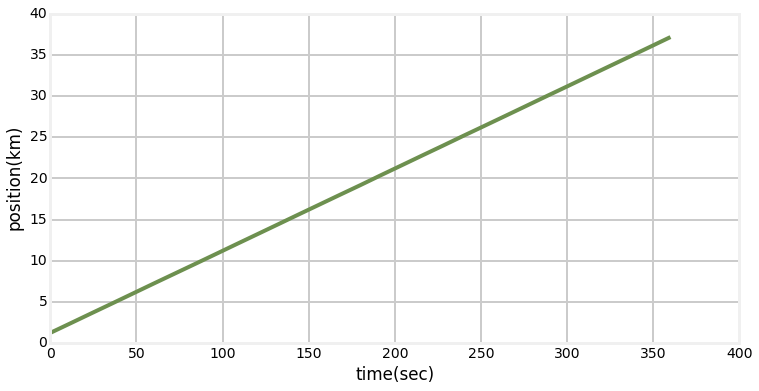

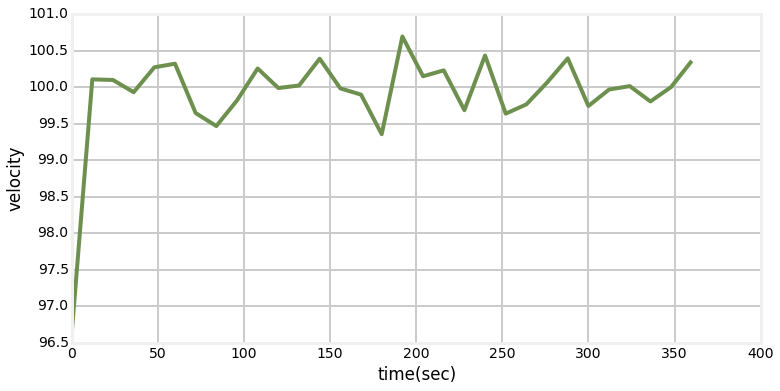

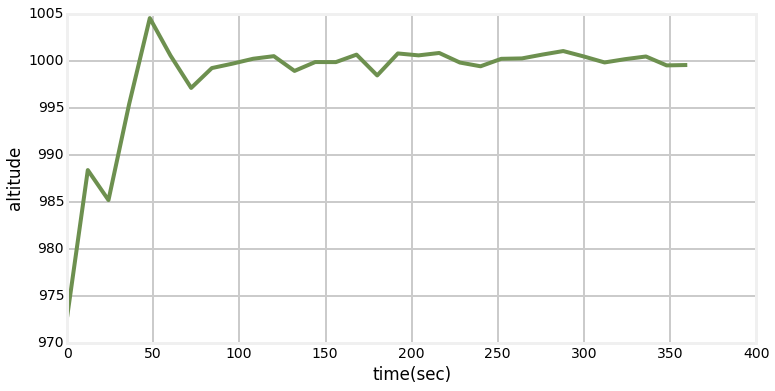

In [45]:
dt = 12. # 12 seconds between readings
range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, kappa=0.)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2,2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])


radar = RadarStation(pos=(0,0), range_std=range_std, bearing_std=bearing_std)
ac = ACSim(ac_pos, (100,0), 0.02)

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

zs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    zs.append([r[0], r[1]])

    
xs, covs = kf.batch_filter(zs)
plot_radar(xs, t)

array([[ 543.41815127,   87.77494672,   -4.89342285],
       [  87.77494672,   14.51416149,    0.01409823],
       [  -4.89342285,    0.01409823,  182.26443823]])

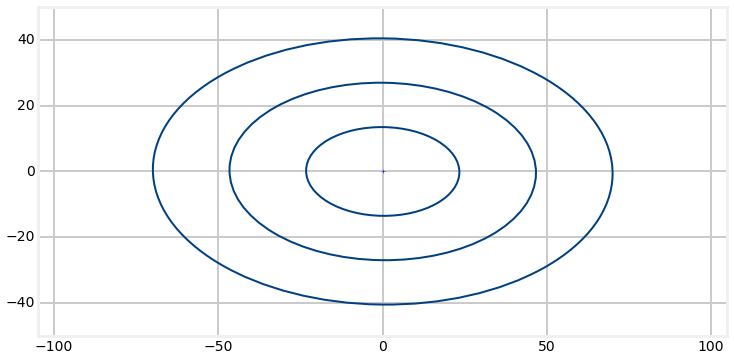

In [46]:
import stats
P= np.array([[kf.P[0,0], kf.P[0, 2]], [kf.P[0,2], kf.P[2,2]]])
stats.plot_covariance_ellipse((0,0), P, variance=[1, 4, 9])
kf.P

## Smoothing the Results

Briefly, the recursive form of Kalman filtering that we have been using up to now use information from the past to generate the current estimate. Recall the last section, where we used batch processing to filter a collection of measurements. This implies that we know now only the past, but the future! This is a key insight.

Let's assume that  we are tracking a car. Suppose we get a noisy measurement that implies that the car is starting to turn to the left, but the state function has predicted that the car is moving straight. The Kalman filter has no choice but to move the state estimate somewhat towards the noisy measurement, as it cannot judge whether this is just a particularly noisy measurement or the true start of a turn. 

However, if we have measurements from the future we can often figure out if a turn was made or not. Suppose the subsequent measurements all continue turning left. We can then be sure that the measurement was not very noisy, but instead a true indication that a turn was initiated. On the other hand, if the subsequent measurements continued on in a straight line we would know that the measurement was noisy and should be mostly ignored.

We will not develop the math or algorithm here, I will just show you how to call the algorithm in `filterpy`. The algorithm that we have implemented is called an *RTS smoother*, after the three inventors of the algorithm: Rauch, Tung, and Striebel.

The routine is `UnscentedKalmanFilter.rts_smoother()`. Using it is trivial; we pass in the means and covariances computed from the `batch_filter` step, and receive back the smoothed means, covariances, and Kalman gain.

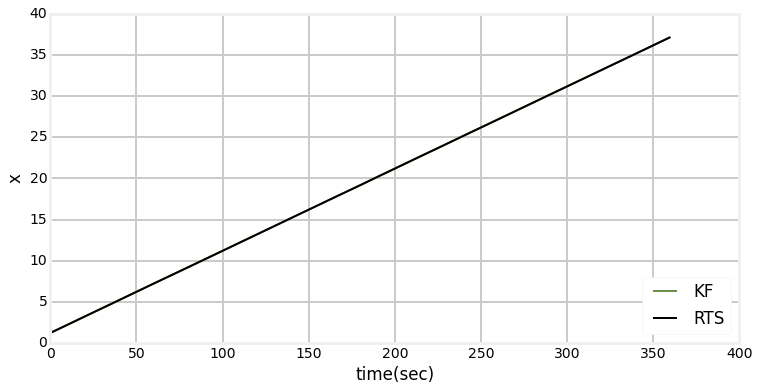

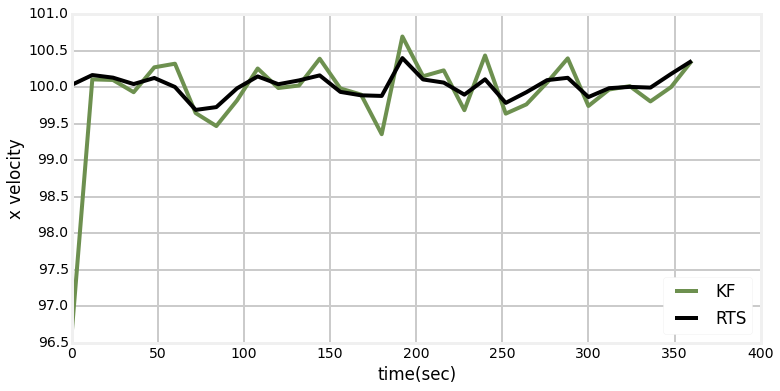

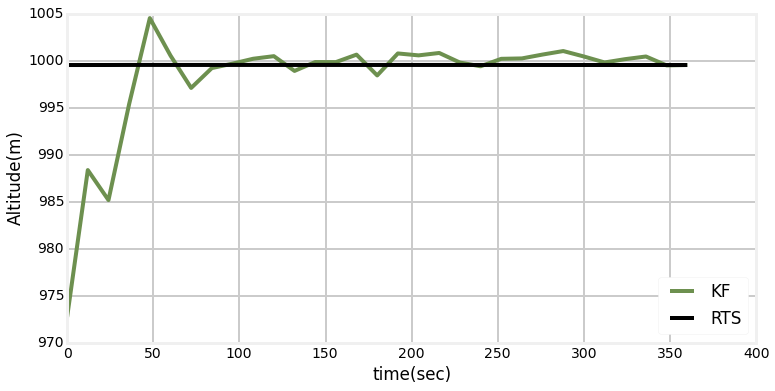

Difference in position in meters: [-0.7689 -0.1184  0.0443 -1.1705 -1.0871]


In [47]:
Ms, P, K = kf.rts_smoother(xs, covs)

plt.figure()
plt.plot(t, xs[:,0]/1000., label='KF', lw=2)
plt.plot(t, Ms[:,0]/1000., c='k', label='RTS', lw=2)
plt.xlabel('time(sec)')
plt.ylabel('x')
plt.legend(loc=4)


plt.figure()

plt.plot(t, xs[:,1], label='KF')
plt.plot(t, Ms[:,1], c='k', label='RTS')
plt.xlabel('time(sec)')
plt.ylabel('x velocity')
plt.legend(loc=4)

plt.figure()
plt.plot(t, xs[:,2], label='KF')
plt.plot(t, Ms[:,2], c='k', label='RTS')
plt.xlabel('time(sec)')
plt.ylabel('Altitude(m)')
plt.legend(loc=4)

plt.show()
np.set_printoptions(precision=4)
print('Difference in position in meters:', xs[-6:-1, 0] - Ms[-6:-1, 0])

From these charts we can see that the improvement in the position is small compared, but the improvement in the velocity good, and spectacular for the altitude. The difference in the position are very small, so I printed the difference between the UKF and the smoothed results for the last 5 points.

## Choosing Values for kappa

I have found the literature on choosing values for $\kappa$ to be rather lacking. Julier's original paper suggests a value of $n+\kappa=3$ if the distribution is Gaussian, and if not a "different choice of $\kappa$ might be more appropriate"[2]. He also describes it as a "fine tun[ing" parameter. So let's just explore what it does. I will let $n=1$ just to minimize the size of the arrays we need to look at.

In [48]:
def print_sigmas(n=1, mean=5, cov=3, kappa=2):
    print('sigmas: ', UKF.sigma_points(mean,  cov, kappa).T[0])
    print('weights:', UKF.weights(n, kappa))
    
print_sigmas(mean=0, cov=3, kappa=2)

sigmas:  [ 0.  3. -3.]
weights: [ 0.6667  0.1667  0.1667]


So what is going on here? We can see that for a mean of 0 the algorithm choose sigma points of 0, 3, and -3, but why? Recall the equation for computing the sigma points:

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\kappa)\Sigma}
\end{aligned}$$

Here you will appreciate my choice of $n=1$ as it reduces everything to scalars, allowing us to avoid computing the square root of matrices. So, for our values the equation is

$$\begin{aligned}
\mathcal{X}_0 &= 0 \\
\mathcal{X}_i &= 0 \pm \sqrt{(1+2)\times 3} \\
&= 0 \pm \sqrt{9} \\
&= \pm 3
\end{aligned}$$

So as $\kappa$ gets larger the sigma points get more spread out. Let's set it to an absurd value.

In [49]:
print_sigmas(mean=0, cov=3, kappa=200)

sigmas:  [  0.      24.5561 -24.5561]
weights: [ 0.995   0.0025  0.0025]


We can see that the sigma point spread starts to be dominated by $\kappa$ ($\sqrt{200*3}$). Here $k+n=201$ instead of the $k+n=3$ suggested by Julier. If our data was Gaussian we'd be incorporating data many standard deviations away from the mean; for nonlinear problems this is unlikely to produce good results. But suppose our distribution was not Gaussian, but instead had very fat tails? We might need to sample from those tails to get a good estimate, and hence it would make sense to make $kappa$ larger (not 200, which was absurdly large just to make the change in the sigma points stark). 

With a similar line of reasoning, suppose that our distribution has nearly no tails - the probability distribution looks more like an inverted parabola. In such a case we'd probably want to pull the sigma points in closer to the mean to avoid sampling in regions where there will never be real data.

Now let's look at the change in the weights. When we have $k+n=3$ the weights were 0.6667 for the mean, and 0.1667 for the two outlying sigma points. On the other hand, when $\kappa=200$ the mean weight shot up to 0.995 and the outlier weights were set to 0.0025. Recall the equations for the weights:

$$\begin{aligned}
W_0 &= \frac{\kappa}{n+\kappa} \\
W_i &= \frac{1}{2(n+\kappa)}
\end{aligned}$$

We can see that as $\kappa$ gets larger the fraction for the weight of the mean ($\kappa/(n+\kappa)$) approaches 1, and the fraction for the weights of the rest of the sigma points approaches 0. This is invariant on the size of your covariance. So as we sample further and further away from the mean we end up giving less weight to those samples, and if we sampled very close to the mean we'd give very similar weights to all.

## The Skewed Unscented Transform

## The Scaled Unscented Transform

In the last section I briefly talked about varying $\kappa$ to fine tune the performance of the filter.

## Nonlinear State Variables

todo

## References

- [1] http://www.esdradar.com/brochures/Compact%20Tracking%2037250X.pdf

- [2] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

- [3] Cholesky decomposition. Wikipedia. http://en.wikipedia.org/wiki/Cholesky_decomposition